## Going Deeper(NLP)_RS5
## 15. Transformer로 번역기 만들기 [프로젝트]
### 15-1. 프로젝트: 더 멋진 번역기 만들기

In [1]:
#라이브러리 임포트
import tensorflow as tf
import numpy as np
import os

import re
import sentencepiece as spm
from tqdm import tqdm
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

#### Step 1. 데이터 다운로드
* 링크 (https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)의 korean-english-park.train.tar.gz 사용
#### Step 2. 데이터 정제 및 토큰화
* 1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거 
###### 데이터의 병렬 쌍이 흐트러지지 않게 주의
###### 중복을 제거한 데이터를 cleaned_corpus 에 저장

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

* 2. 정제 함수를 아래 조건을 만족하게 정의
###### 모든 입력을 소문자로 변환
###### 알파벳, 문장부호, 한글만 남기고 모두 제거
###### 문장부호 양옆에 공백을 추가
###### 문장 앞뒤의 불필요한 공백을 제거

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower() # 소문자 변환
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z0-9?.!,]+", " ", sentence) # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장부호 양옆 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)       # 문장 앞뒤 불필요한 공백 제거
    
    return sentence

* 3. 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행
###### 토큰화에는 Sentencepiece를 활용
* 아래 조건을 만족하는 generate_tokenizer() 함수를 정의 (링크 https://github.com/google/sentencepiece 참고) 
###### 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 할 것 (기본: 20,000)
###### 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환
###### 특수 토큰의 인덱스를 아래와 동일하게 지정
###### <PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3
* 최종적으로 ko_tokenizer 과 en_tokenizer 를 생성 
###### en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 할 것

In [4]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    temp_file = os.getenv('HOME') + f'/aiffel/transformer/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=/aiffel/aiffel/transformer/spm_{lang} --vocab_size={vocab_size}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'/aiffel/aiffel/transformer/spm_{lang}.model')

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/transformer/corpus_ko.txt --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=/aiffel/aiffel/transformer/spm_ko --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/transformer/corpus_ko.txt
  input_format: 
  model_prefix: /aiffel/aiffel/transformer/spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
 

True

* 4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환
###### 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간 소요

In [5]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])

    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

#### Step 3. 모델 설계
* Positional Encoding

In [6]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

* Multi-Head Attention

In [7]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

* Position-wise Feed-Forward Network

In [8]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

* Encoder layer

In [9]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

* Decoder layer

In [10]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

* Encoder class 정의

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

* Decoder class 정의

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

* Transformer 완성

In [13]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

* Masking

In [14]:
def generate_padding_mask(seq): #  Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

#### Step 4. 훈련하기
* 1. 2 Layer를 가지는 Transformer를 선언
###### 하이퍼파라미터는 자유롭게 조절

In [15]:
transformer = Transformer(
    n_layers=2,
    d_model=128,
    n_heads=8,
    d_ff=512,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

* 2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언
###### Optimizer의 파라미터 역시 논문과 동일하게 설정

In [16]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [17]:
learning_rate = LearningRateScheduler(128)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

* 3. Loss 함수를 정의
###### Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가 (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문)

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

* 4. train_step 함수를 정의
###### 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 할 것

In [19]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

* Attention 시각화 함수

In [20]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

* 번역 생성 함수

In [21]:


def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

* 번역 생성 및 Attention 시각화 결합

In [22]:
# translate() 함수의 plot_attention 변수를 True 로 주면 번역 결과에 대한 Attention Map을 시각화

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

* 5. 학습을 진행
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 좋은 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출

In [23]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 32
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_1301/3361031846.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama s obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the plane was found in the capital .
Input: 커피는 필요 없다.
Predicted translation: the bush administration has been a big
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the people were killed in the capital .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the people of the city , where the city of city is a city of city .
Input: 커피는 필요 없다.
Predicted translation: it s not even if you can be able to get out .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death of the death of the death .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key member of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is a largely small town .
Input: 커피는 필요 없다.
Predicted translation: it is not enough .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key .
Input: 시민들은 도시 속에 산다.
Predicted translation: people are living in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee costs are not enough .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deadly killed at least 15 people .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a former president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a greatest living in the city .
Input: 커피는 필요 없다.
Predicted translation: no one is not known .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed in the death toll .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: people are hoping to be the city .
Input: 커피는 필요 없다.
Predicted translation: don t need to be able to get any .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: people are citying the city of a mountain .
Input: 커피는 필요 없다.
Predicted translation: he never needs a little .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was the toll .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city , one city is a city .
Input: 커피는 필요 없다.
Predicted translation: no longer protected .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was the result of the death toll .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city , is a place where the city is a place where city city is a placed in the city .
Input: 커피는 필요 없다.
Predicted translation: no coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was the worst .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: people are going to be a place in the city .
Input: 커피는 필요 없다.
Predicted translation: no one would need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was the highest toll from the ⁇  .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a black .
Input: 시민들은 도시 속에 산다.
Predicted translation: people are going to be in the city .
Input: 커피는 필요 없다.
Predicted translation: no any older is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was the highest toll in the hardest hit .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president , obama said .
Input: 시민들은 도시 속에 산다.
Predicted translation: people on the city of irbil .
Input: 커피는 필요 없다.
Predicted translation: it does not need any .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deadly wounded were the death toll .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a black .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are a greatest part of the city .
Input: 커피는 필요 없다.
Predicted translation: it doesn t need a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the people were killed and four were unidentifiedly injured .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a black president .
Input: 시민들은 도시 속에 산다.
Predicted translation: people are only a 40th night of the city s largest city .
Input: 커피는 필요 없다.
Predicted translation: it needs very different than the community .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deadly wounded were the death toll .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: people in placed on the old mountain border .
Input: 커피는 필요 없다.
Predicted translation: it does not need a full scale .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead was the highest person .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a black .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a largest city .
Input: 커피는 필요 없다.
Predicted translation: it does not need any .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll is the highest toll in the early breaking .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people in the middle of the war .
Input: 커피는 필요 없다.
Predicted translation: it needs a full picture of people to be called it serious .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was the high of 14 people .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a black dress for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people love the war once .
Input: 커피는 필요 없다.
Predicted translation: it s not need to take tuesday .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the people were killed and the death toll in the past seven days .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a black card .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people . . . .
Input: 커피는 필요 없다.
Predicted translation: it s not a possible threat .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven was dead only 22 people .


  0%|          | 0/2228 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a black democratic party .
Input: 시민들은 도시 속에 산다.
Predicted translation: many people here are going to be .
Input: 커피는 필요 없다.
Predicted translation: it needs very large base .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll is the highest toll from the low .


Input: 오바마는 대통령이다.
Predicted translation: obama is a black democratic party .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


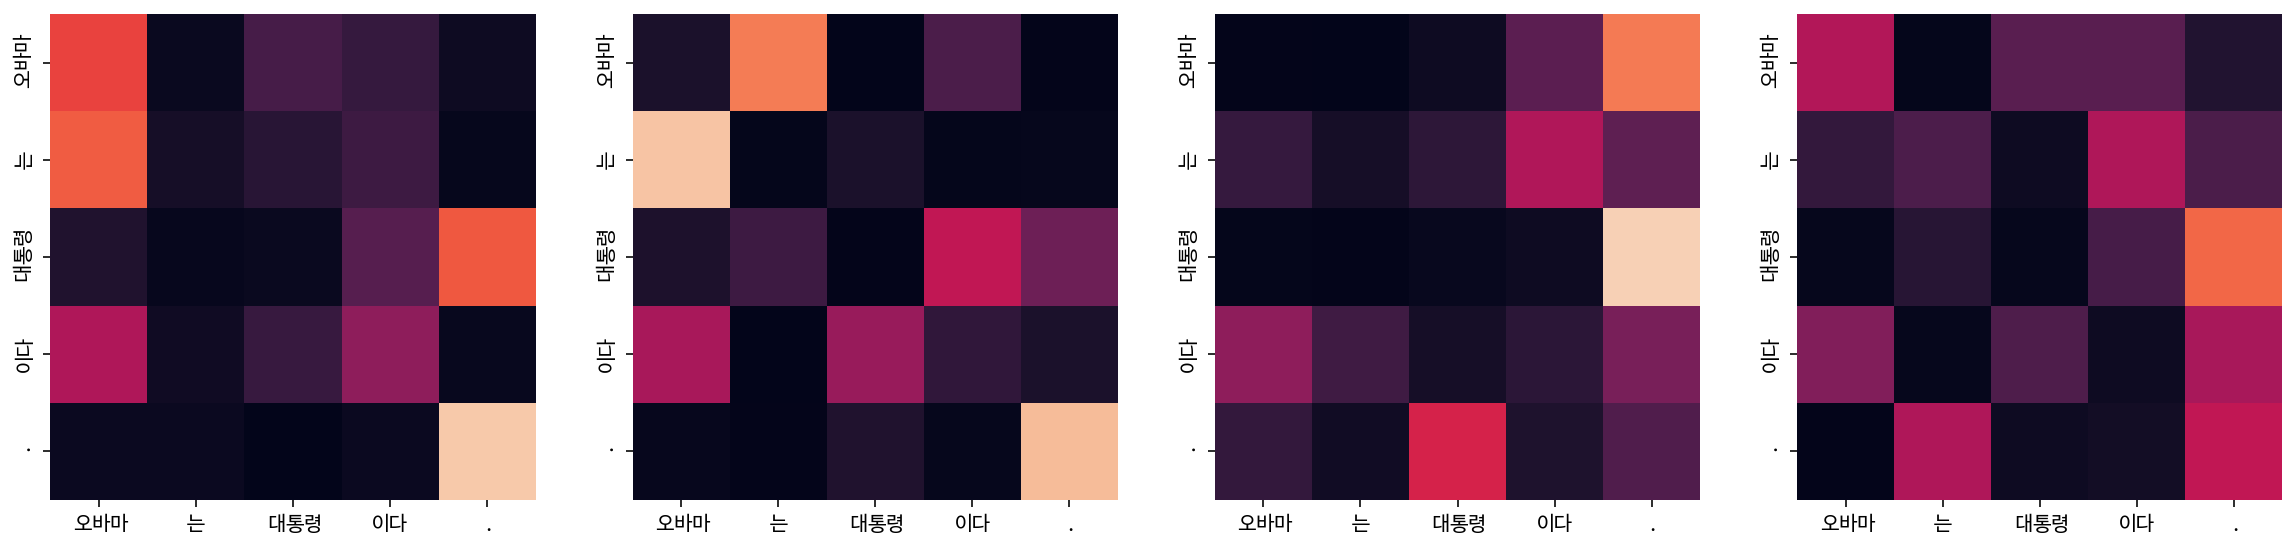

Encoder Layer 2


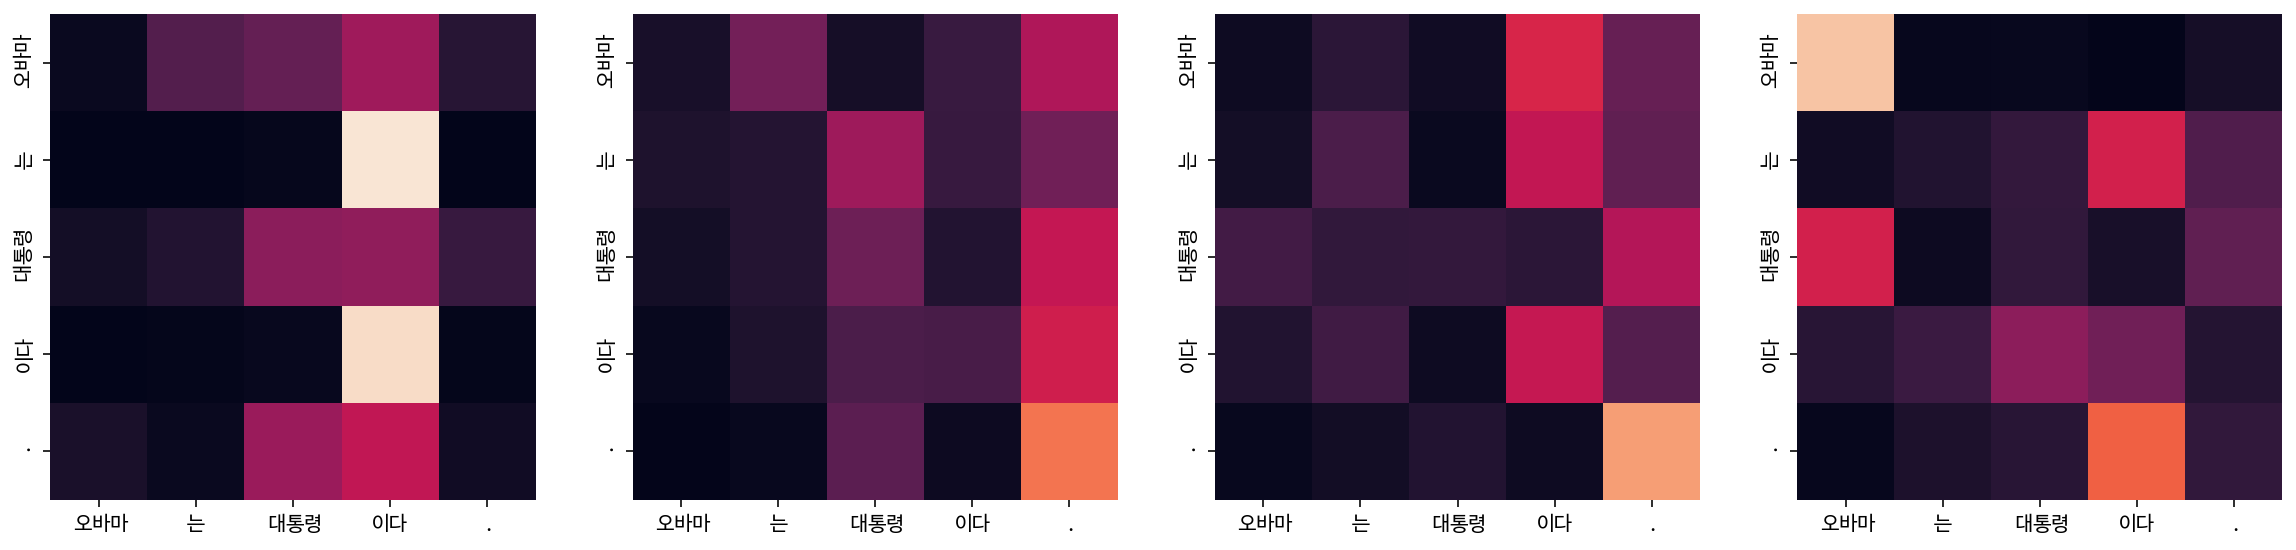

Decoder Self Layer 1


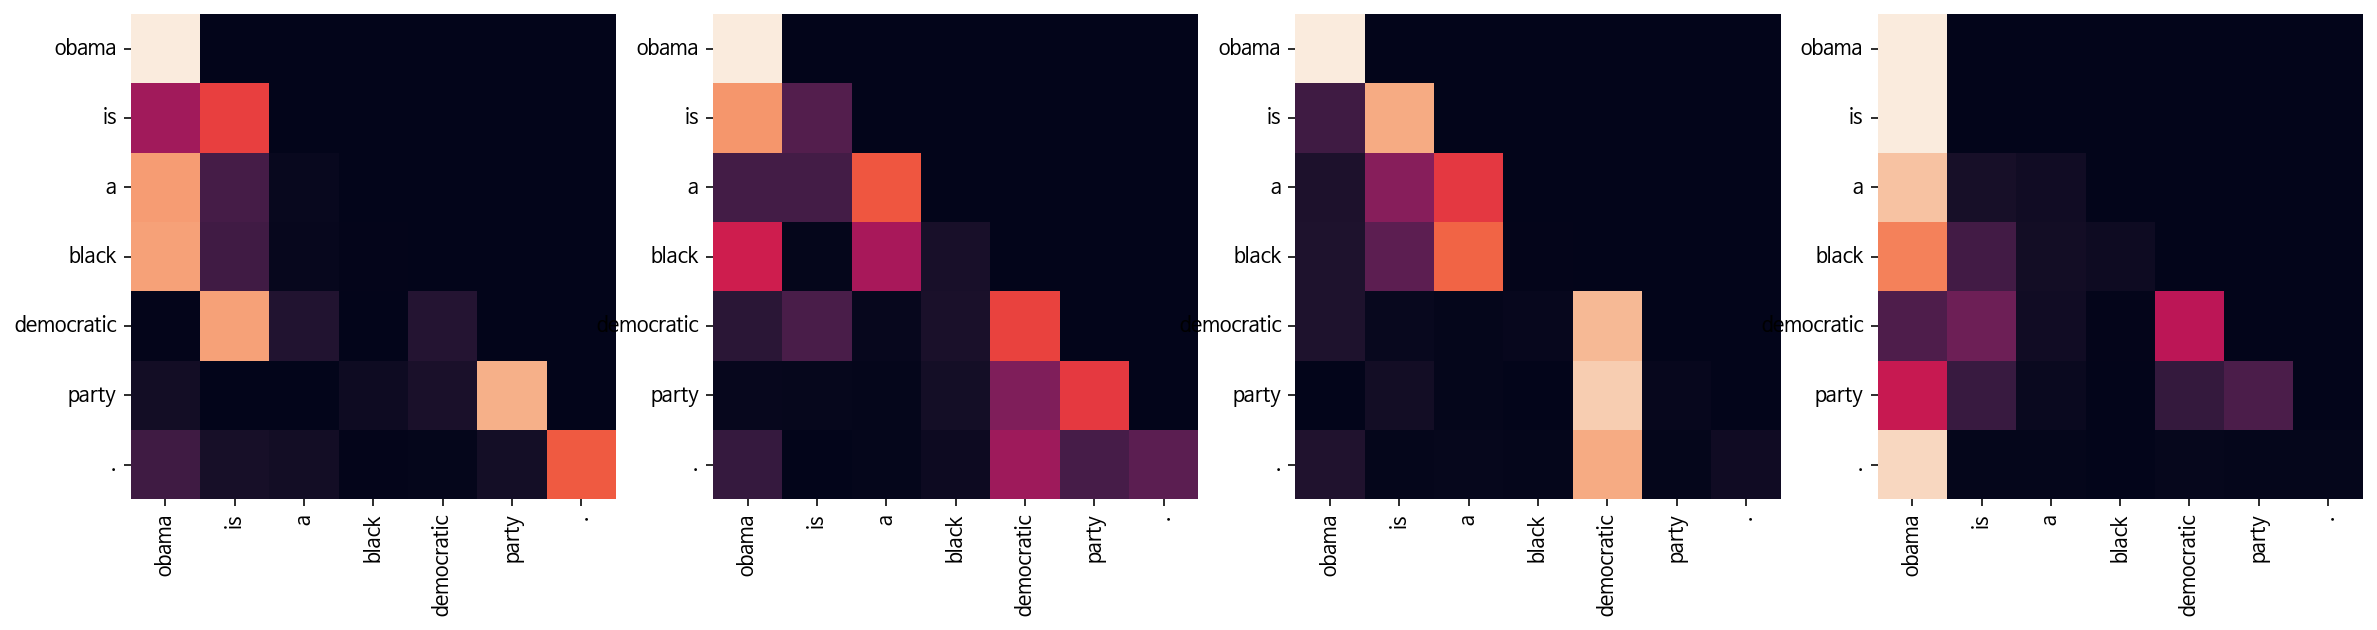

Decoder Src Layer 1


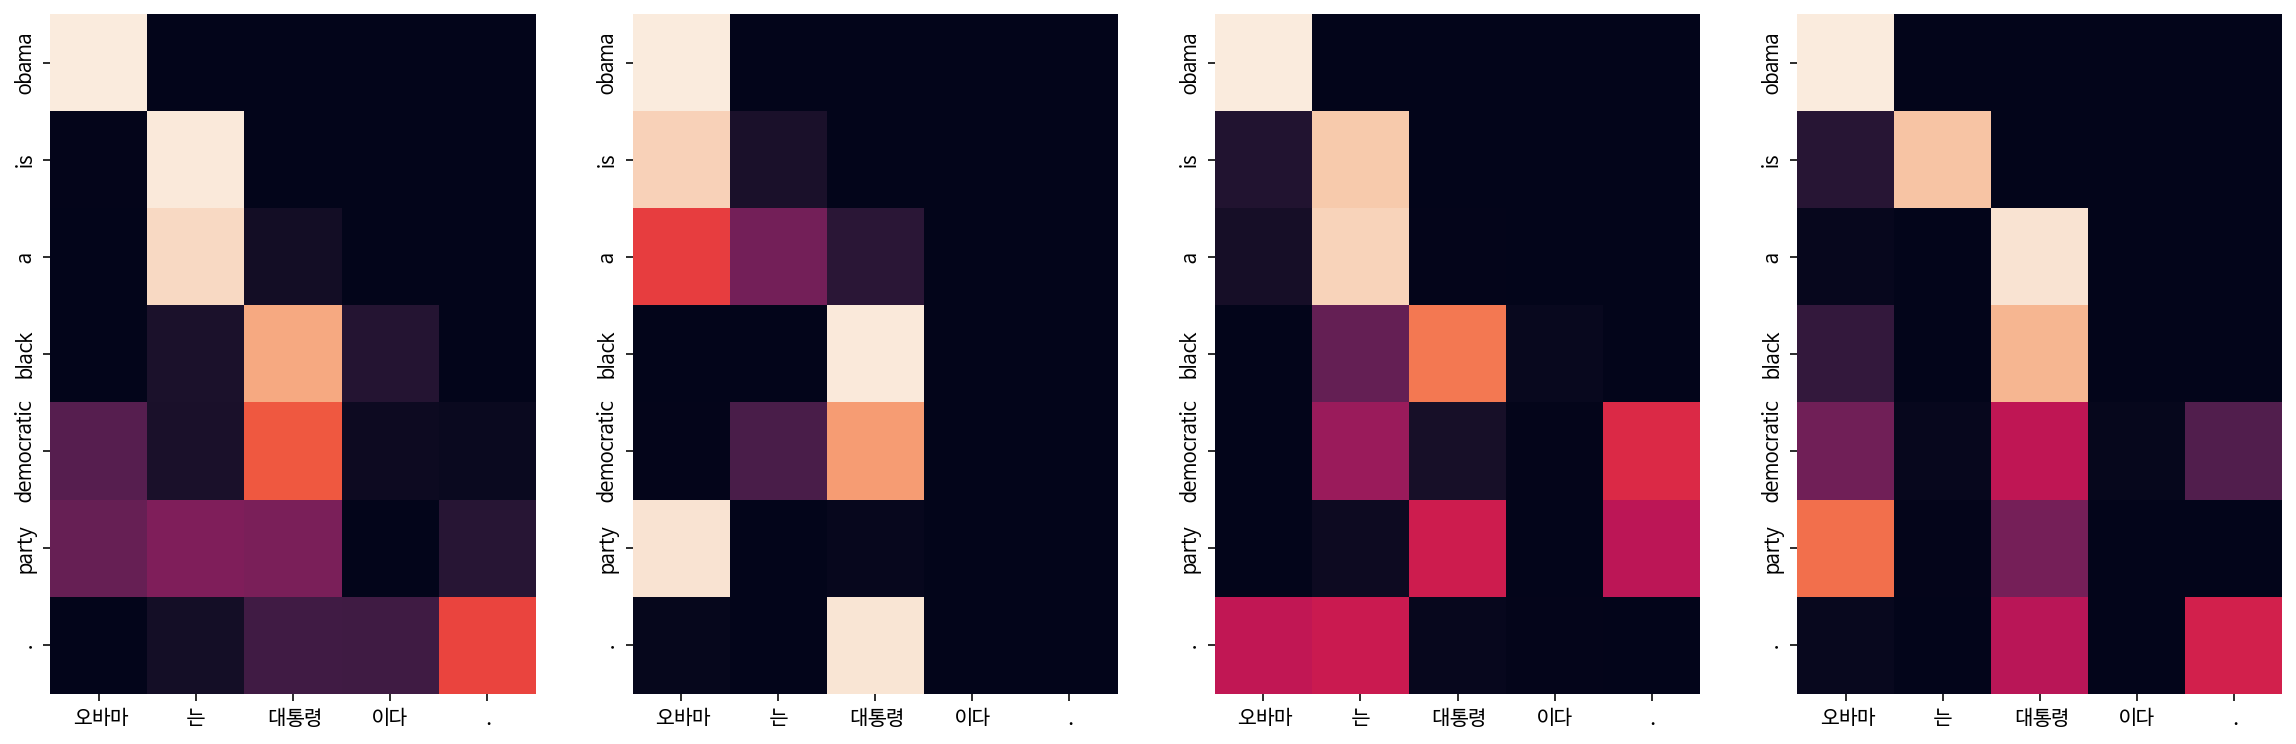

Decoder Self Layer 2


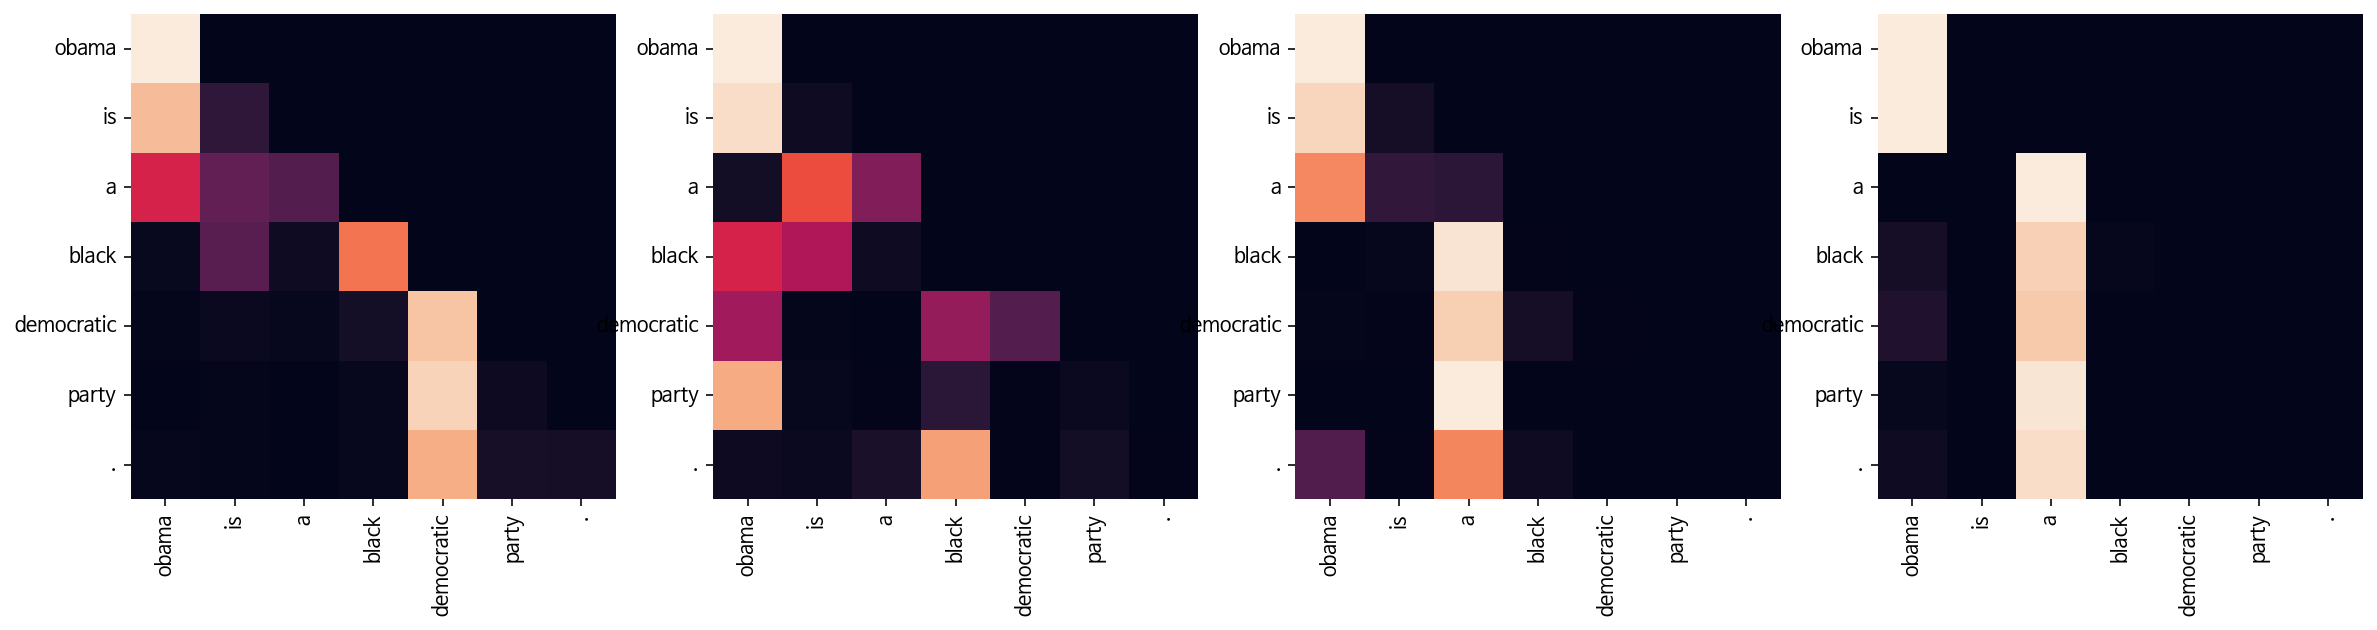

Decoder Src Layer 2


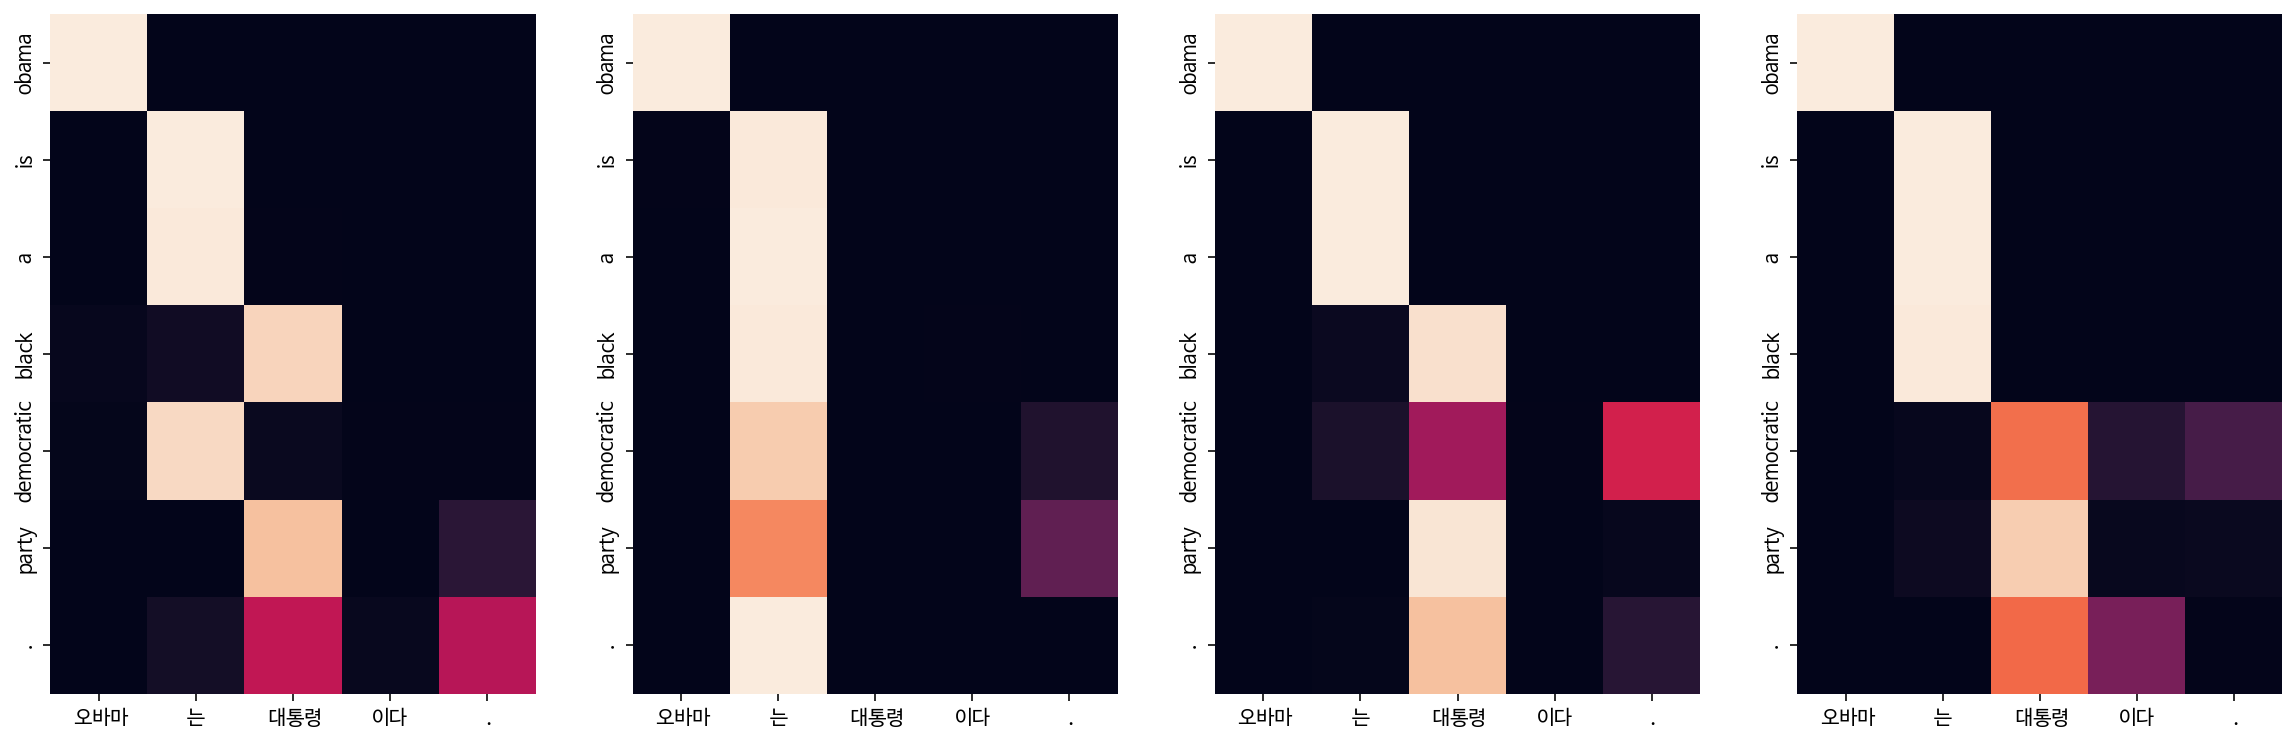

Input: 시민들은 도시 속에 산다.
Predicted translation: many people here are going to be .
Encoder Layer 1


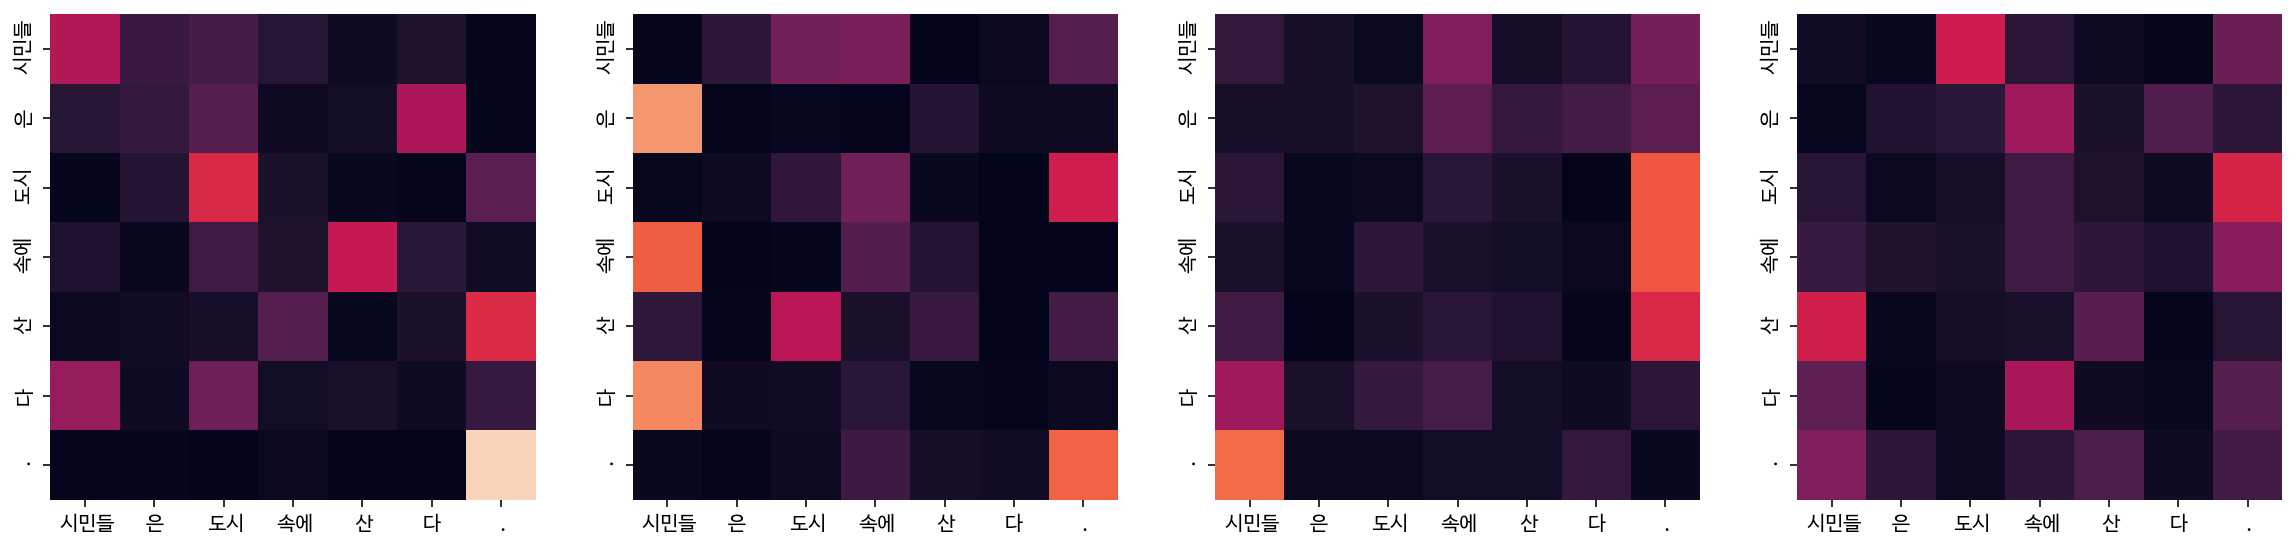

Encoder Layer 2


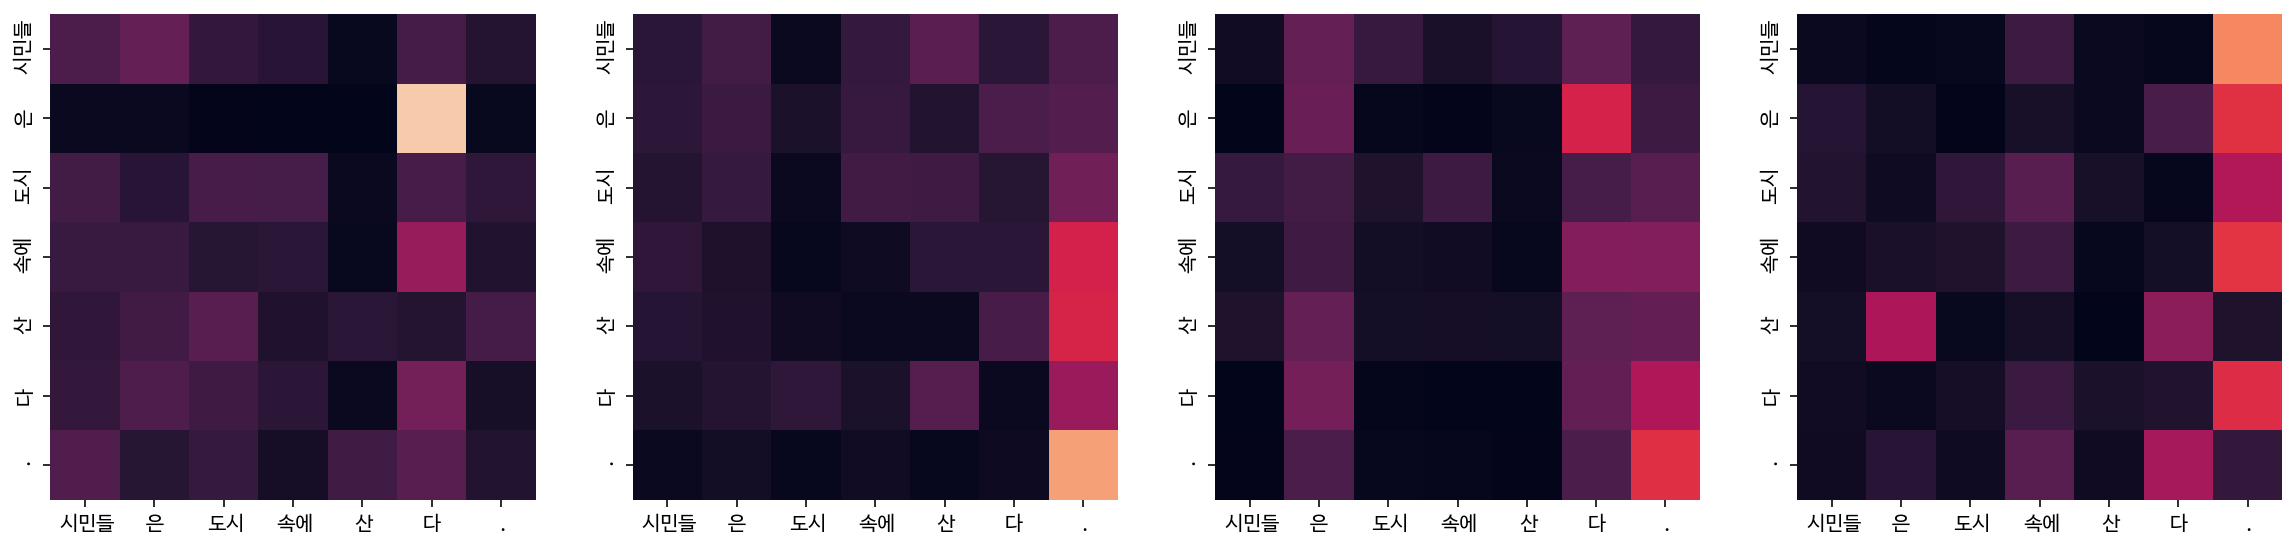

Decoder Self Layer 1


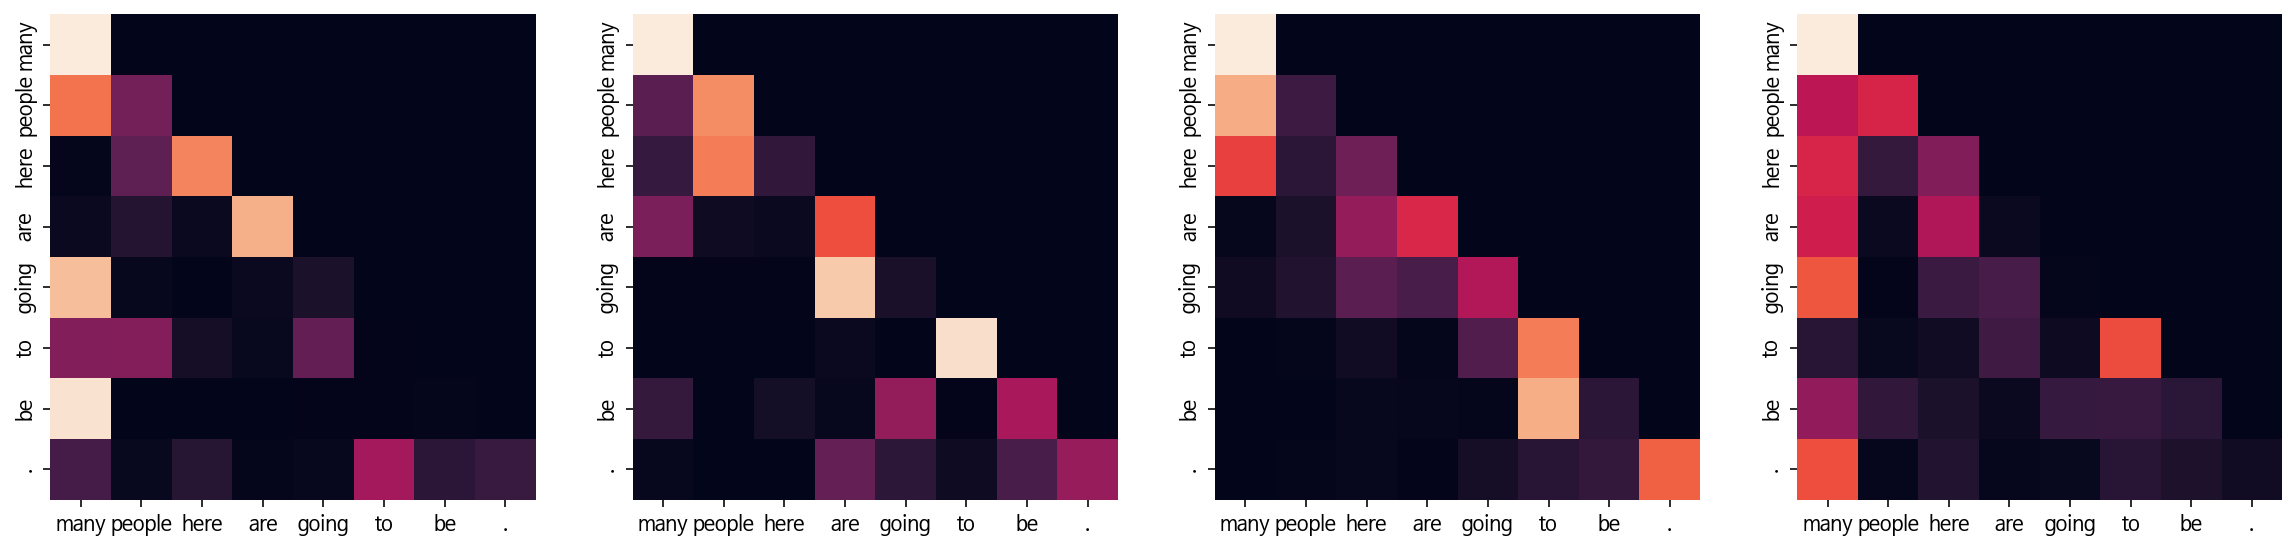

Decoder Src Layer 1


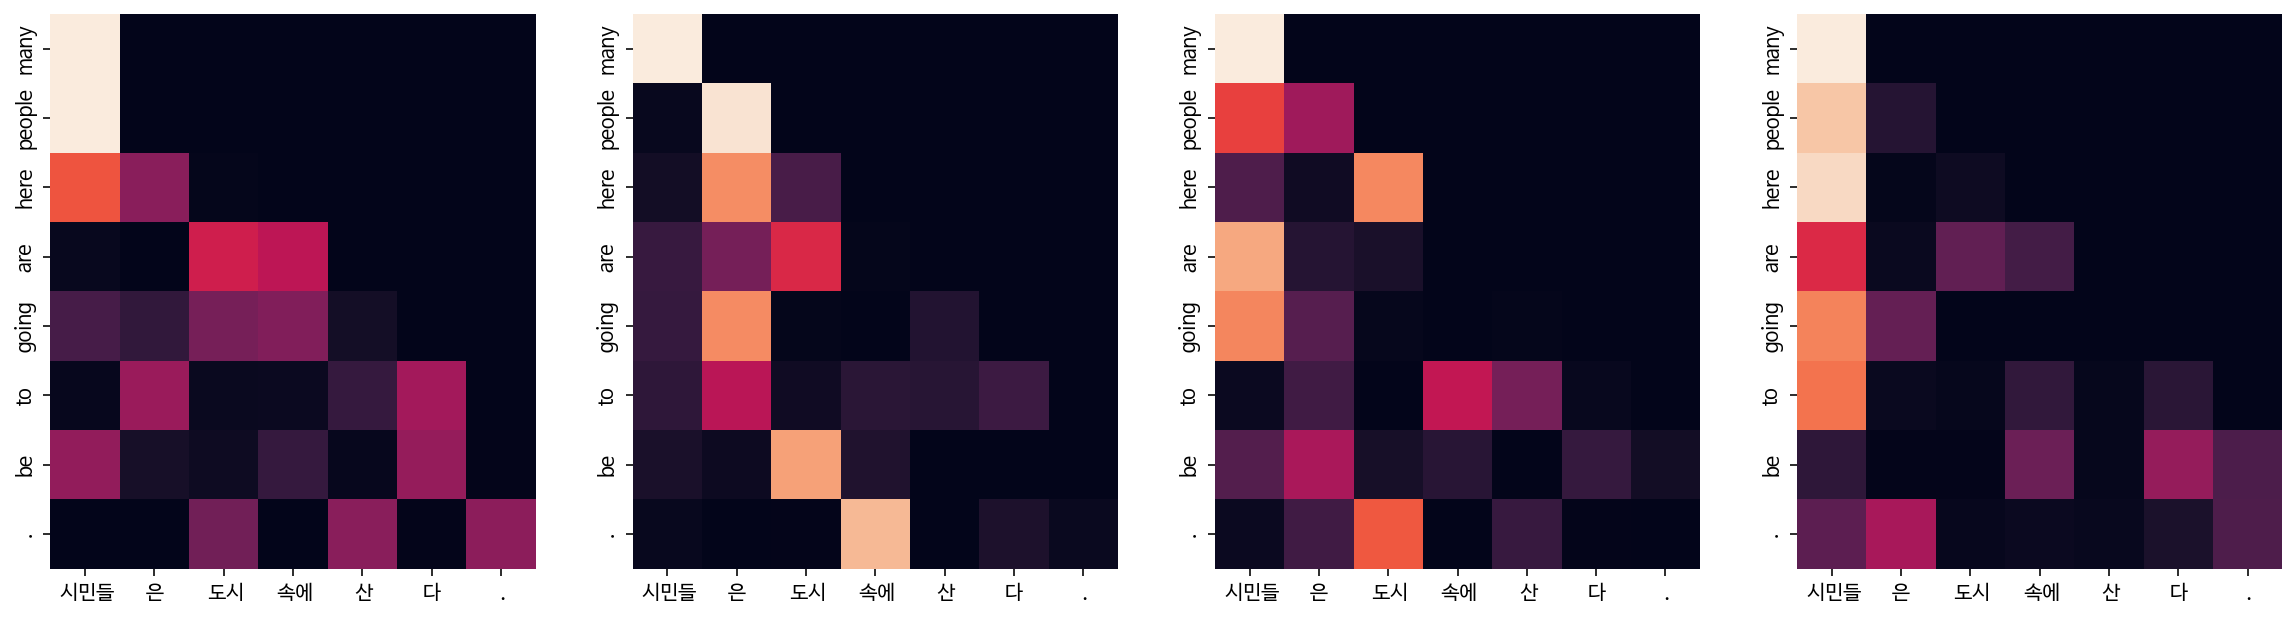

Decoder Self Layer 2


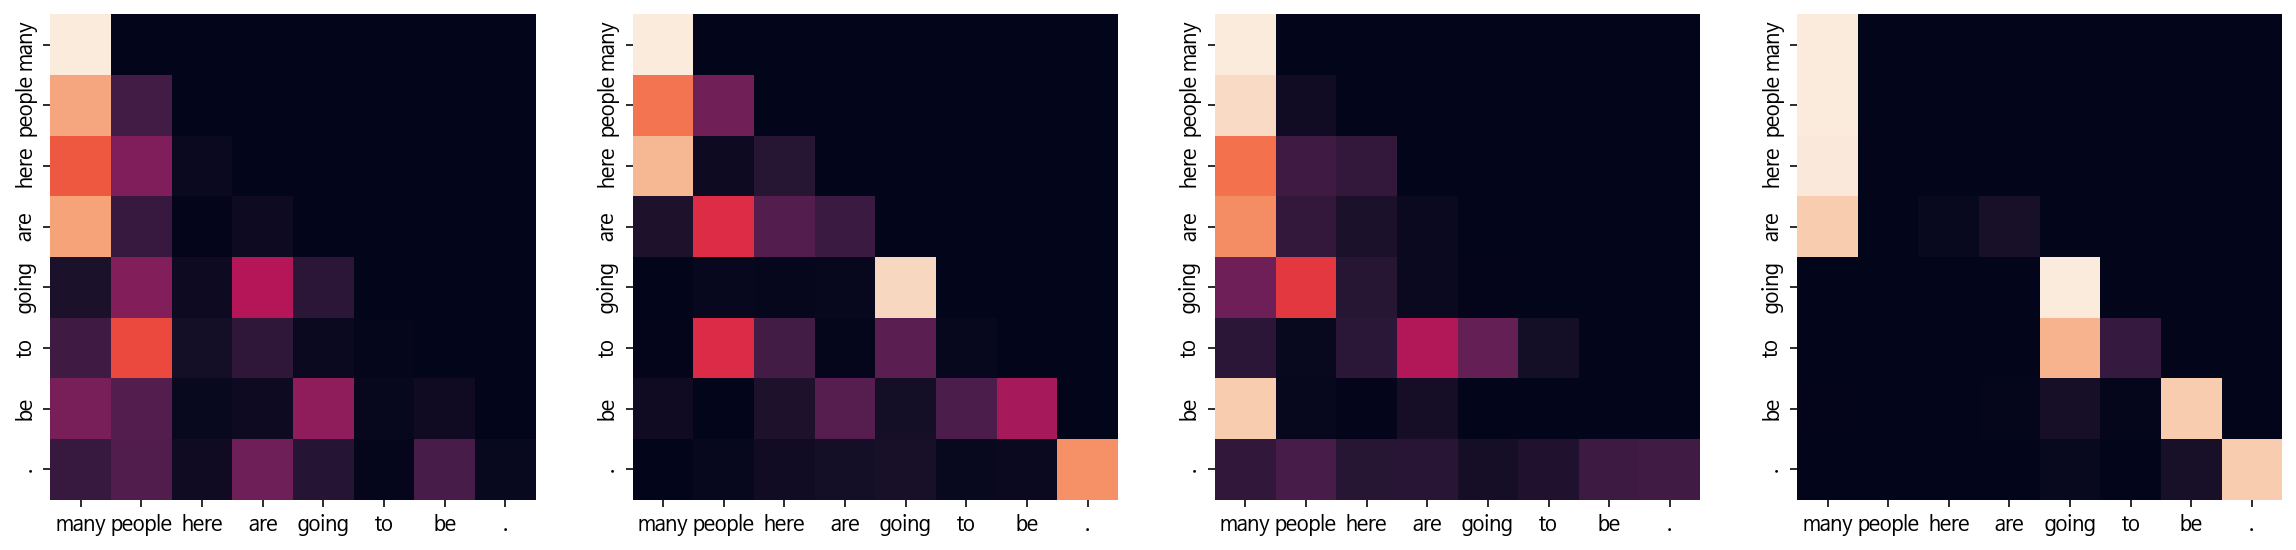

Decoder Src Layer 2


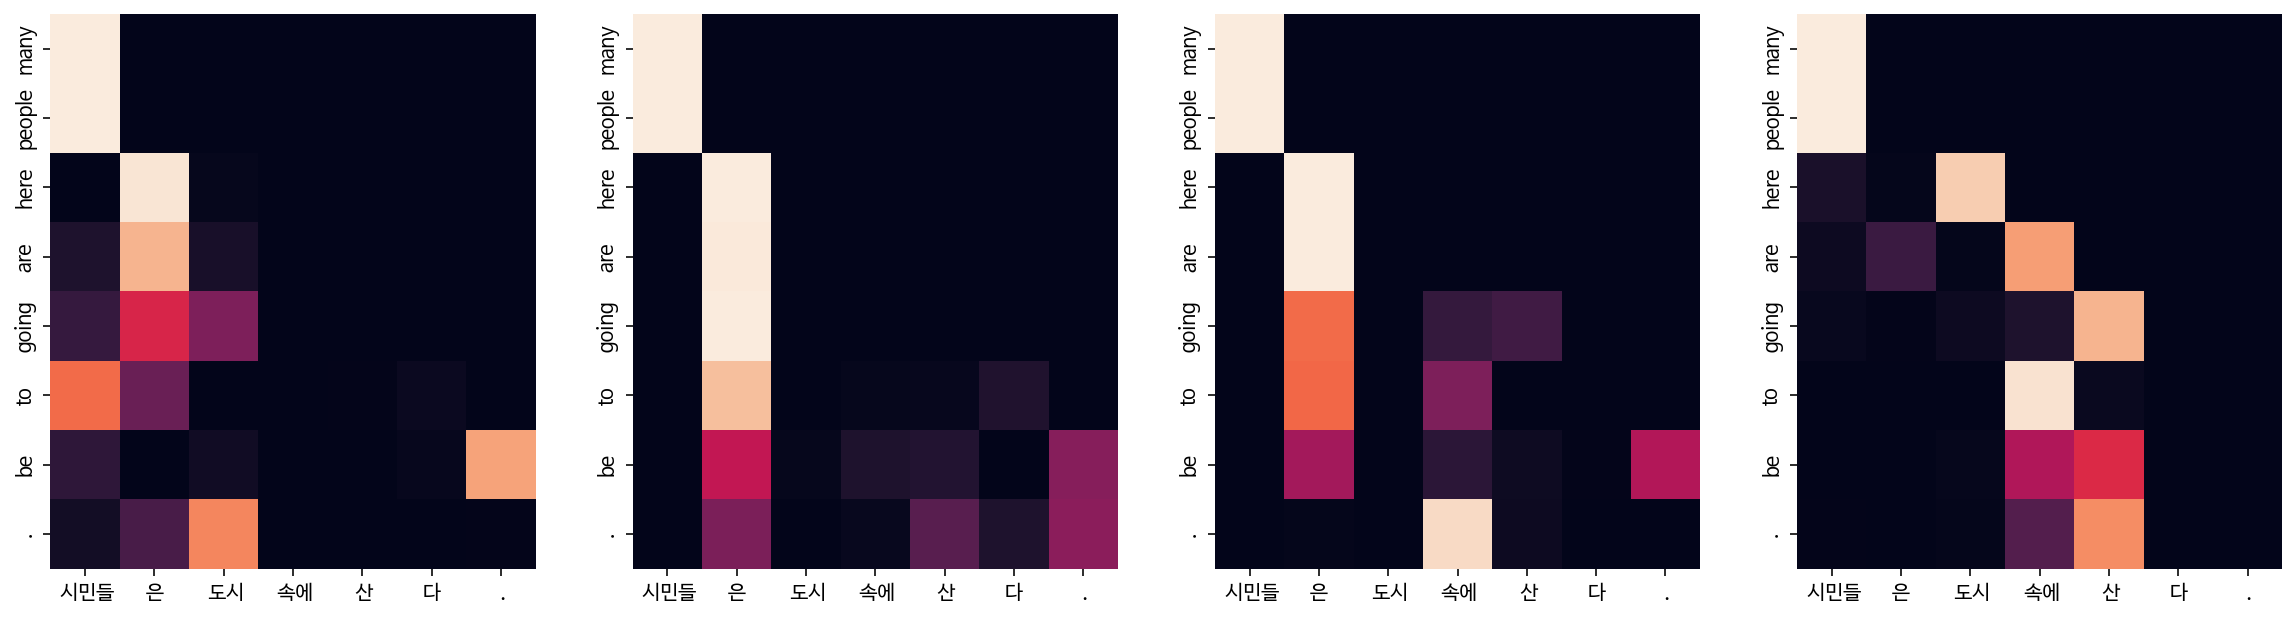

Input: 커피는 필요 없다.
Predicted translation: it needs very large base .
Encoder Layer 1


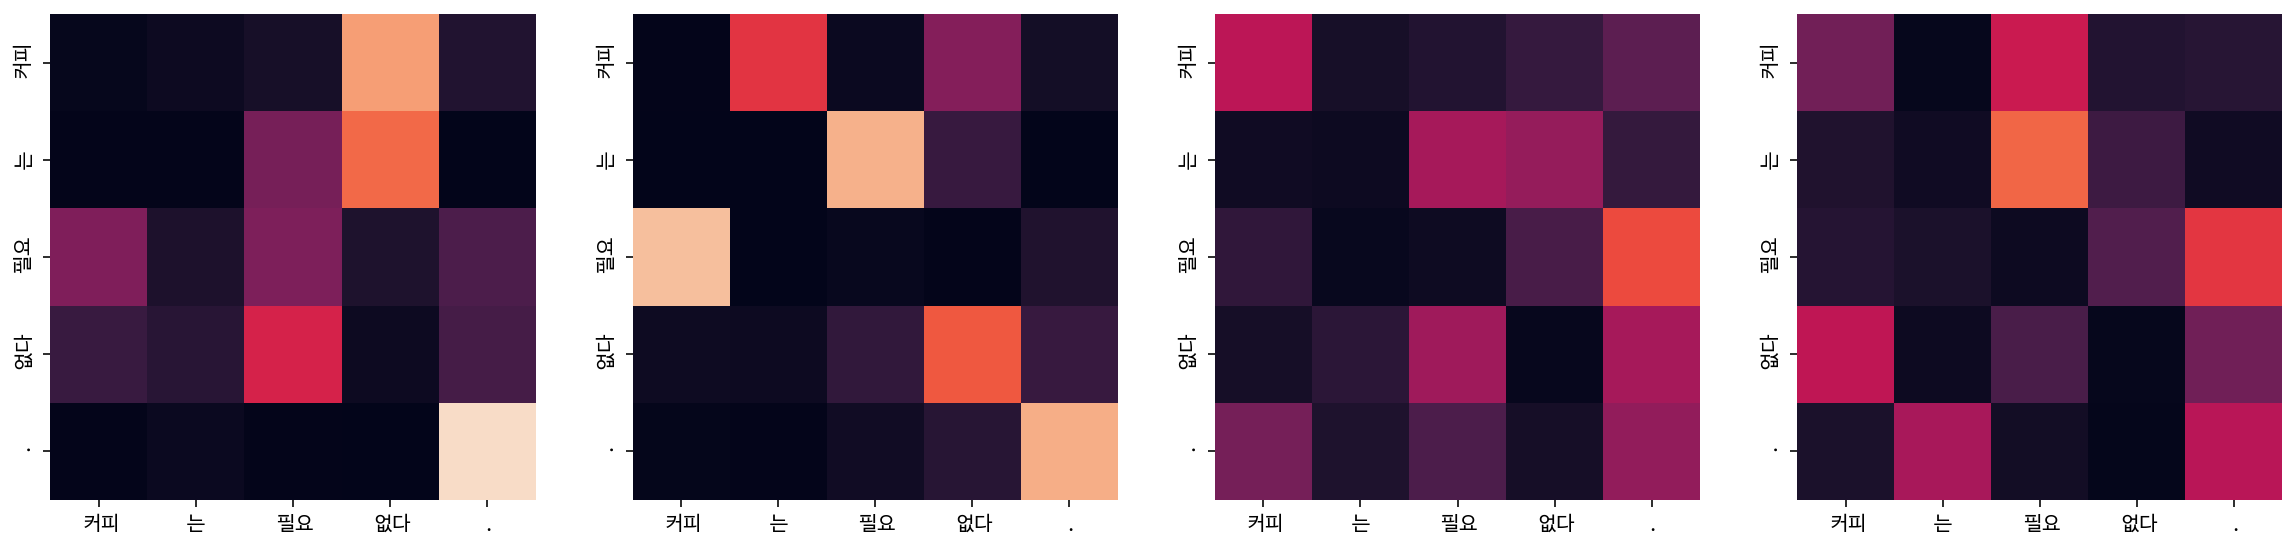

Encoder Layer 2


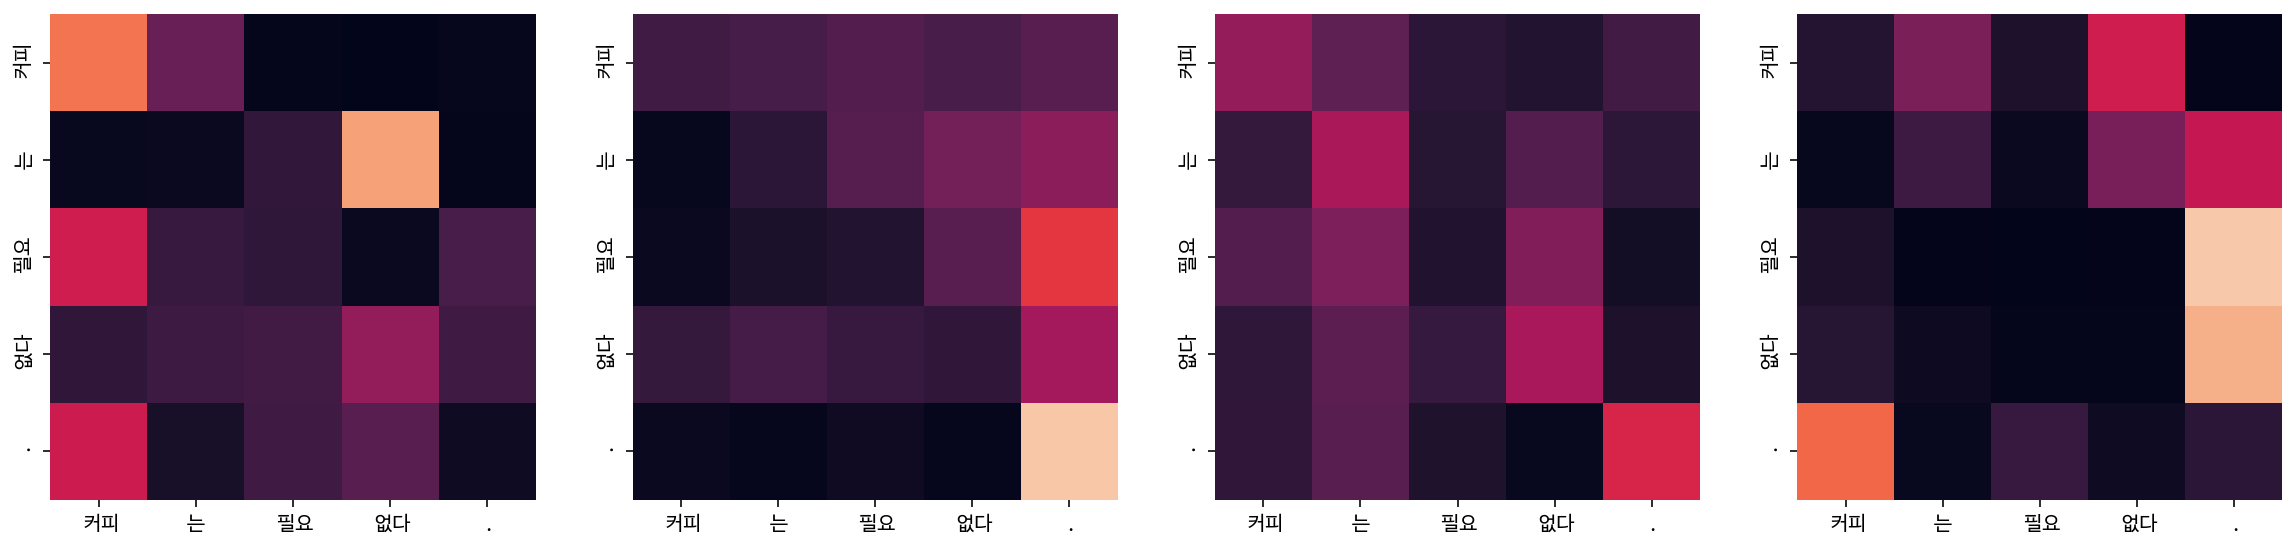

Decoder Self Layer 1


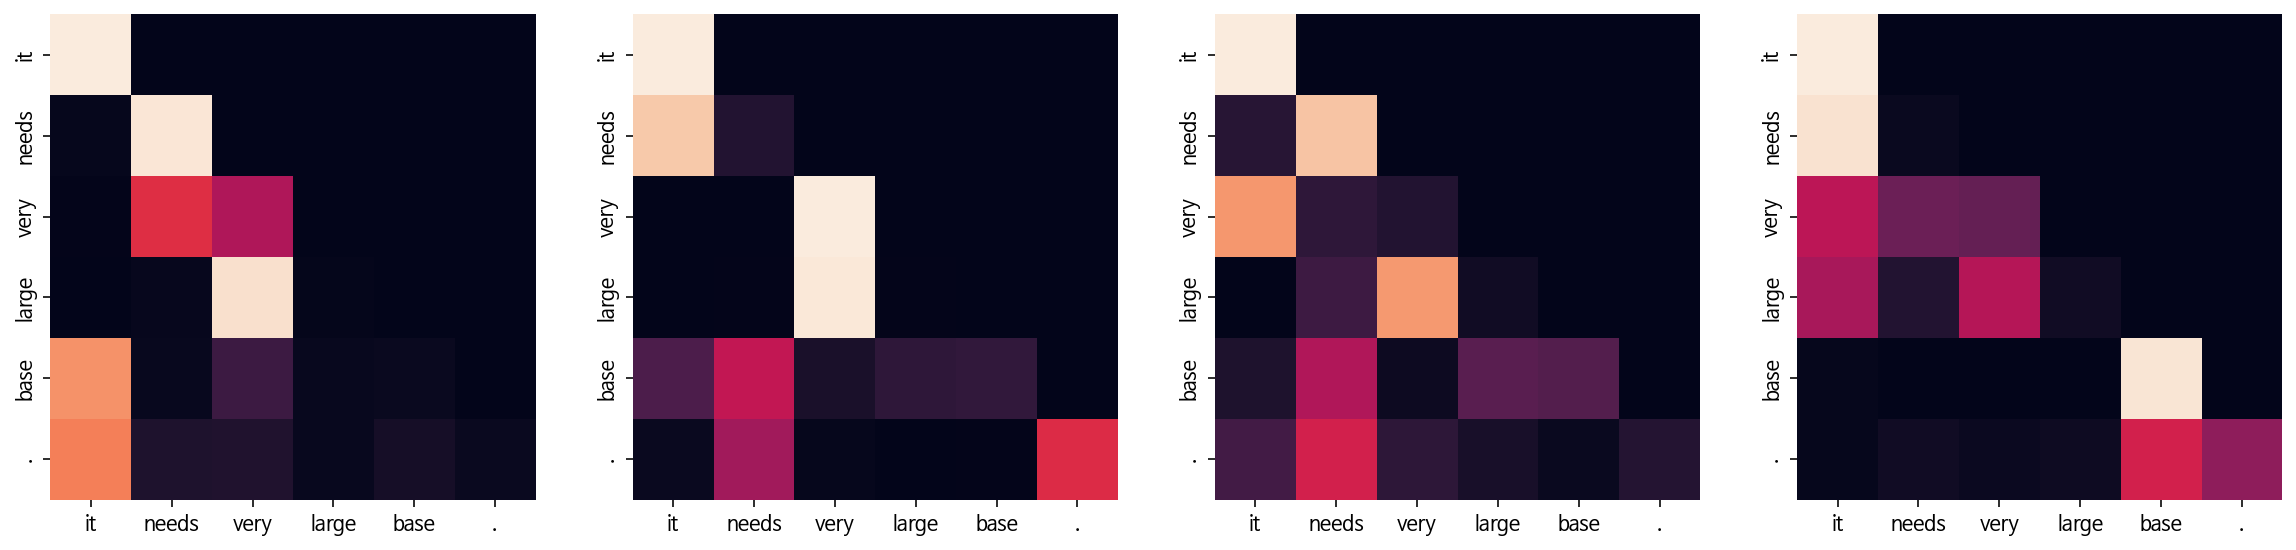

Decoder Src Layer 1


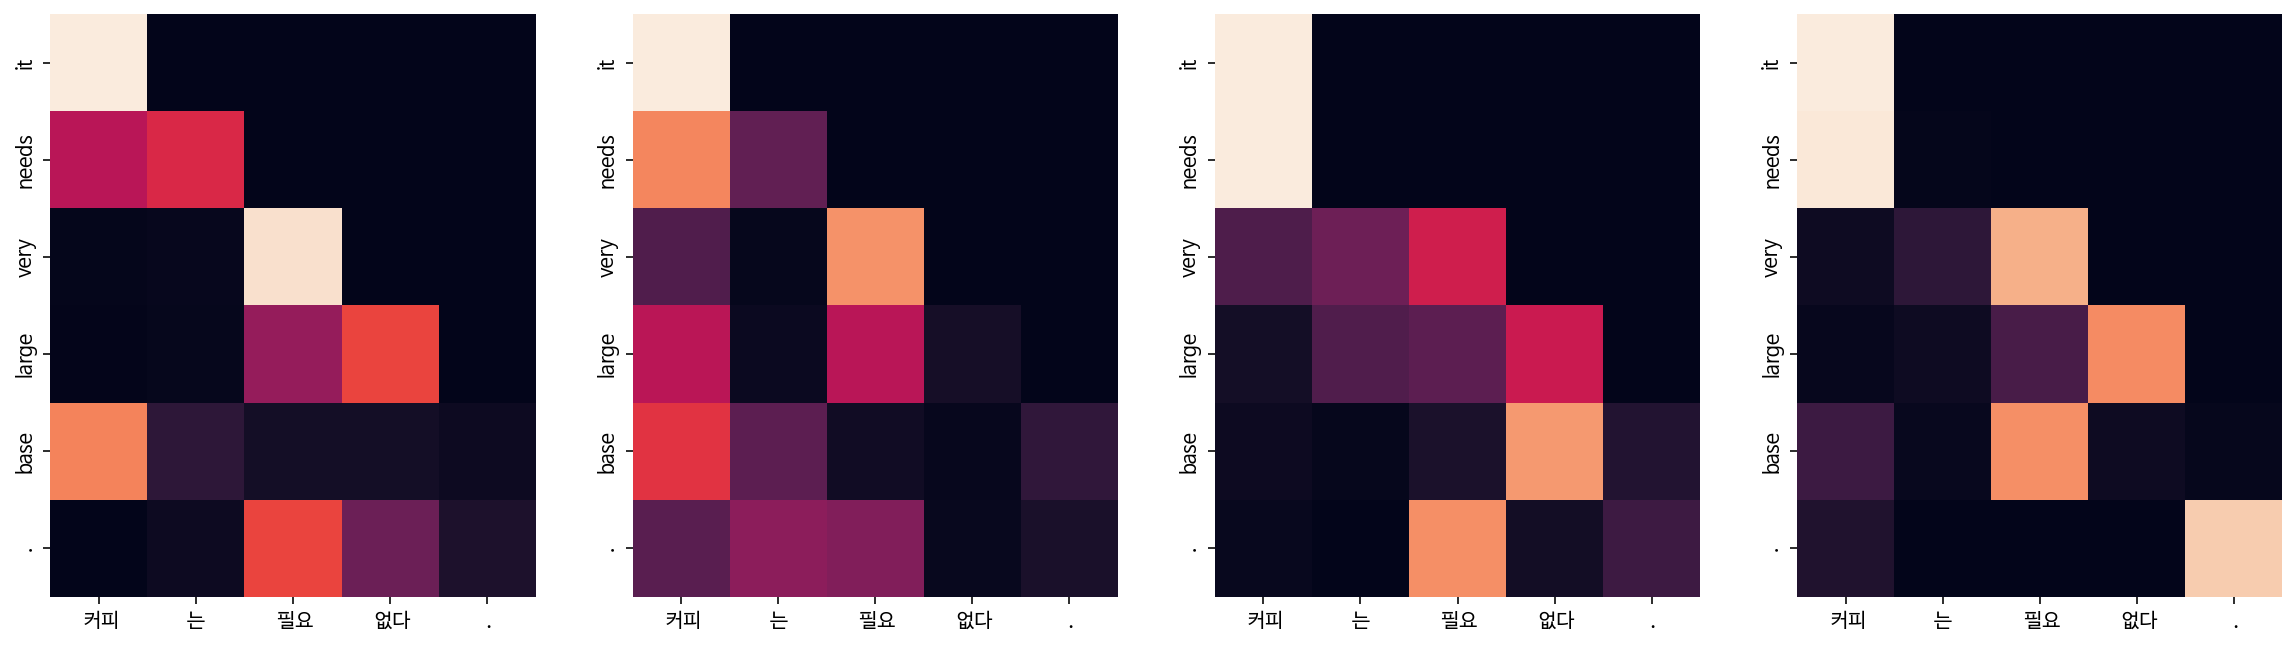

Decoder Self Layer 2


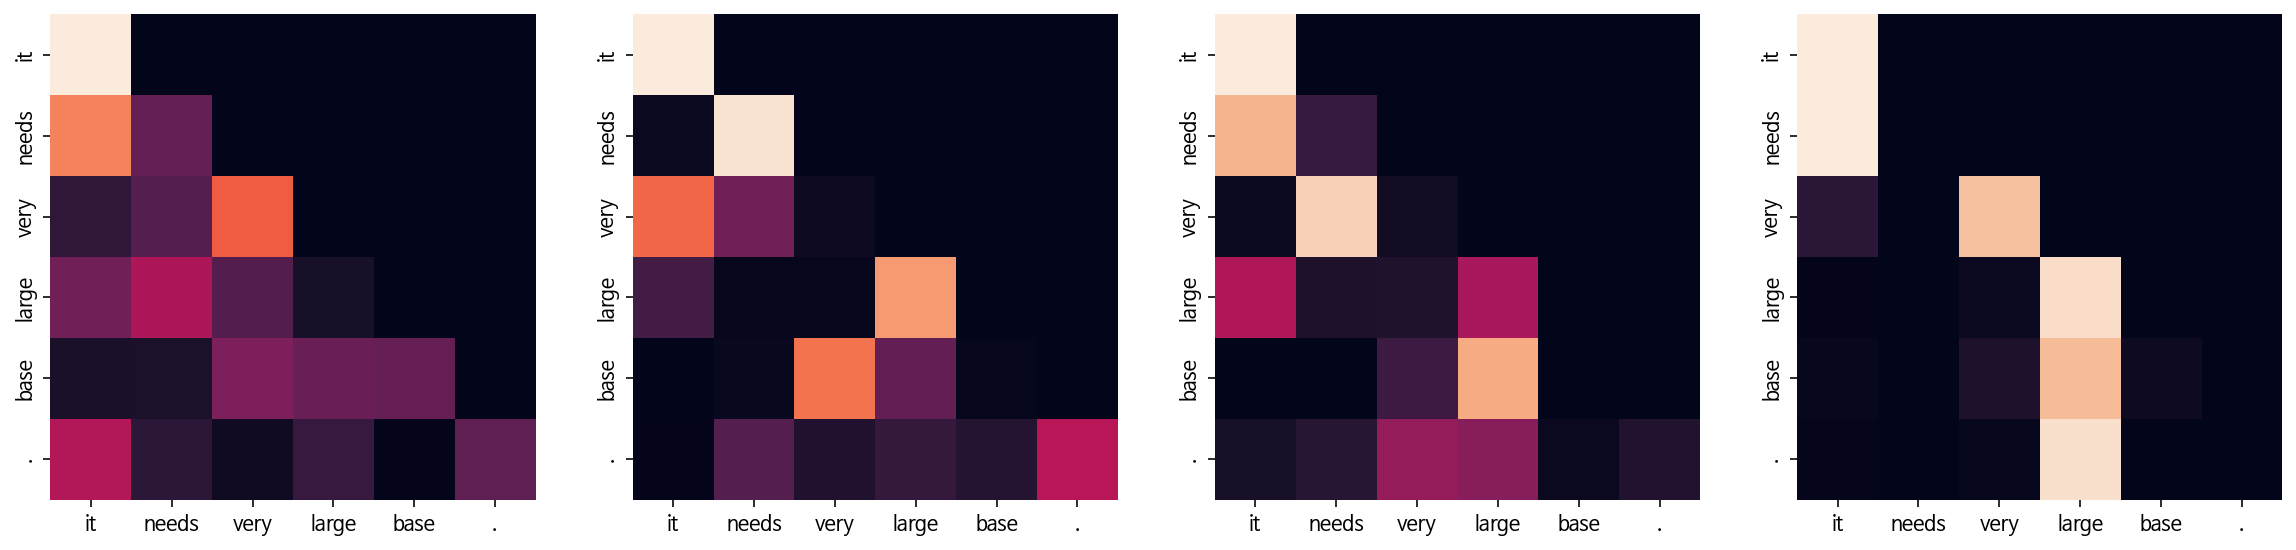

Decoder Src Layer 2


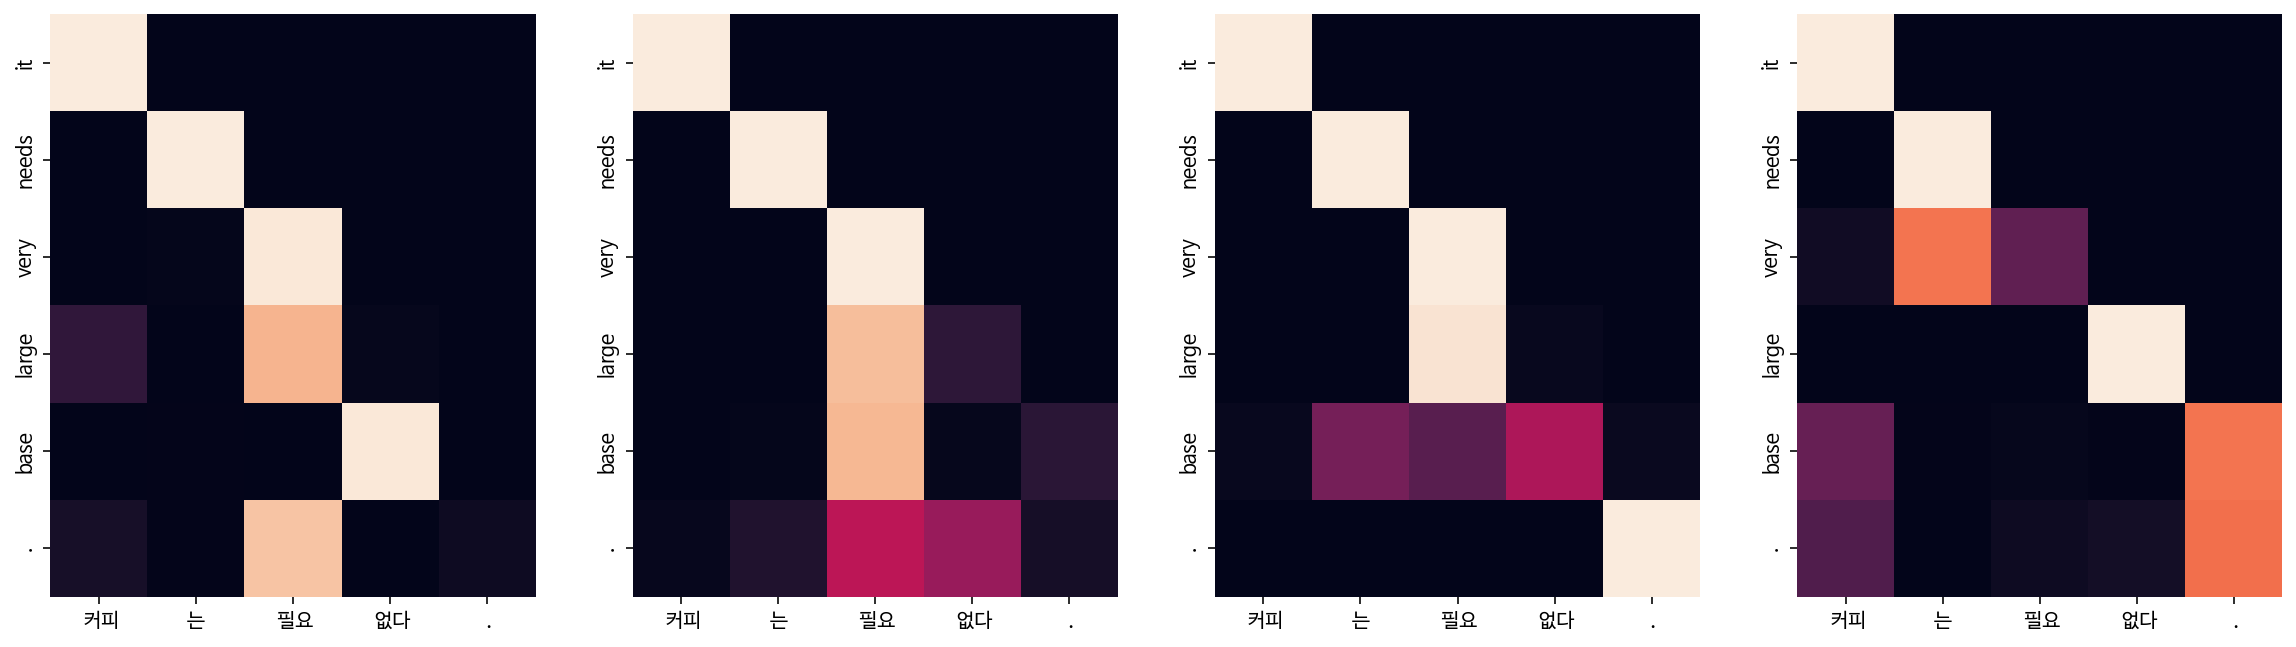

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll is the highest toll from the low .
Encoder Layer 1


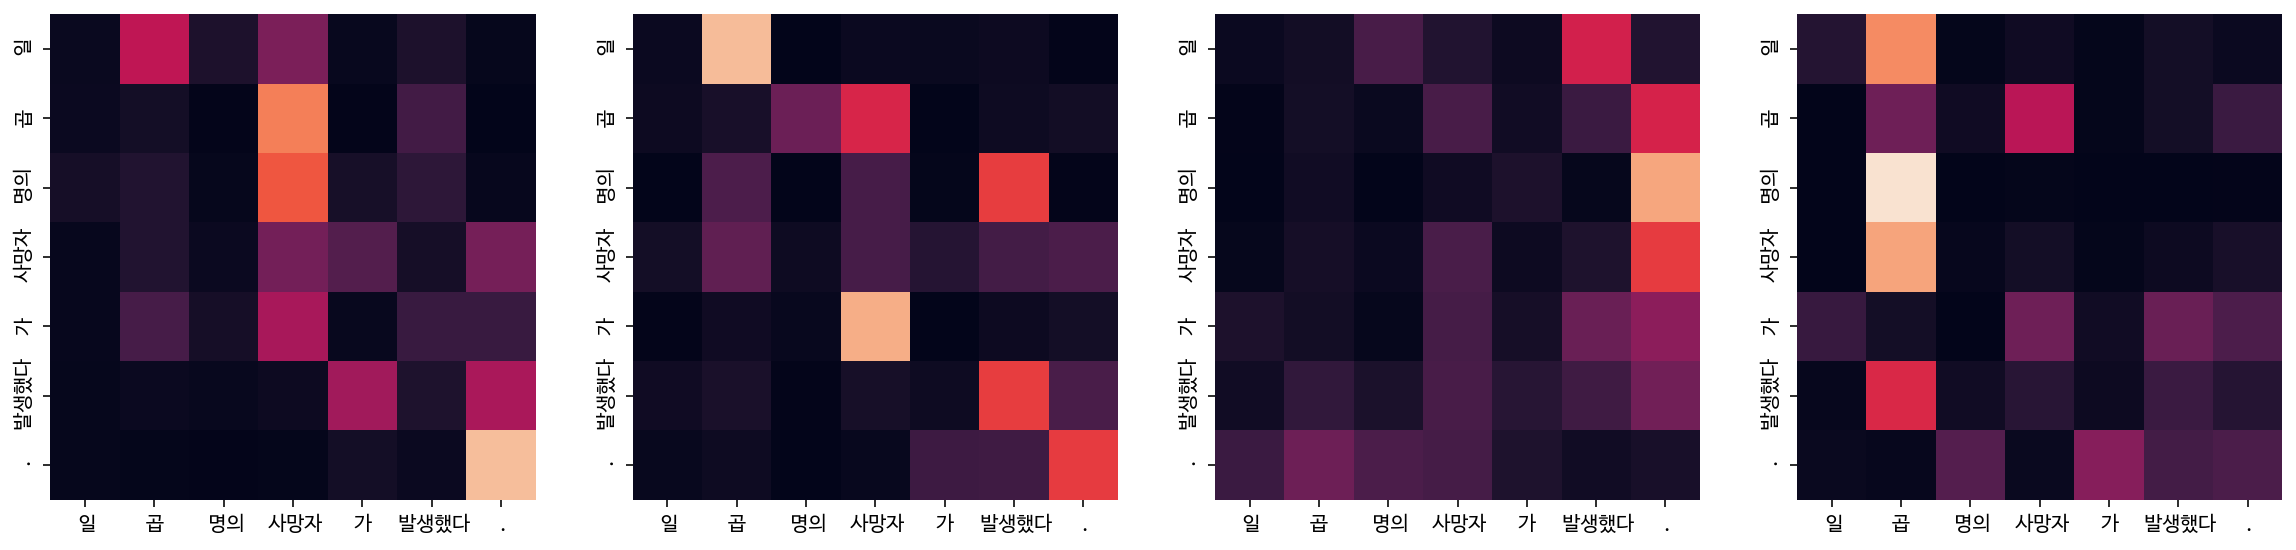

Encoder Layer 2


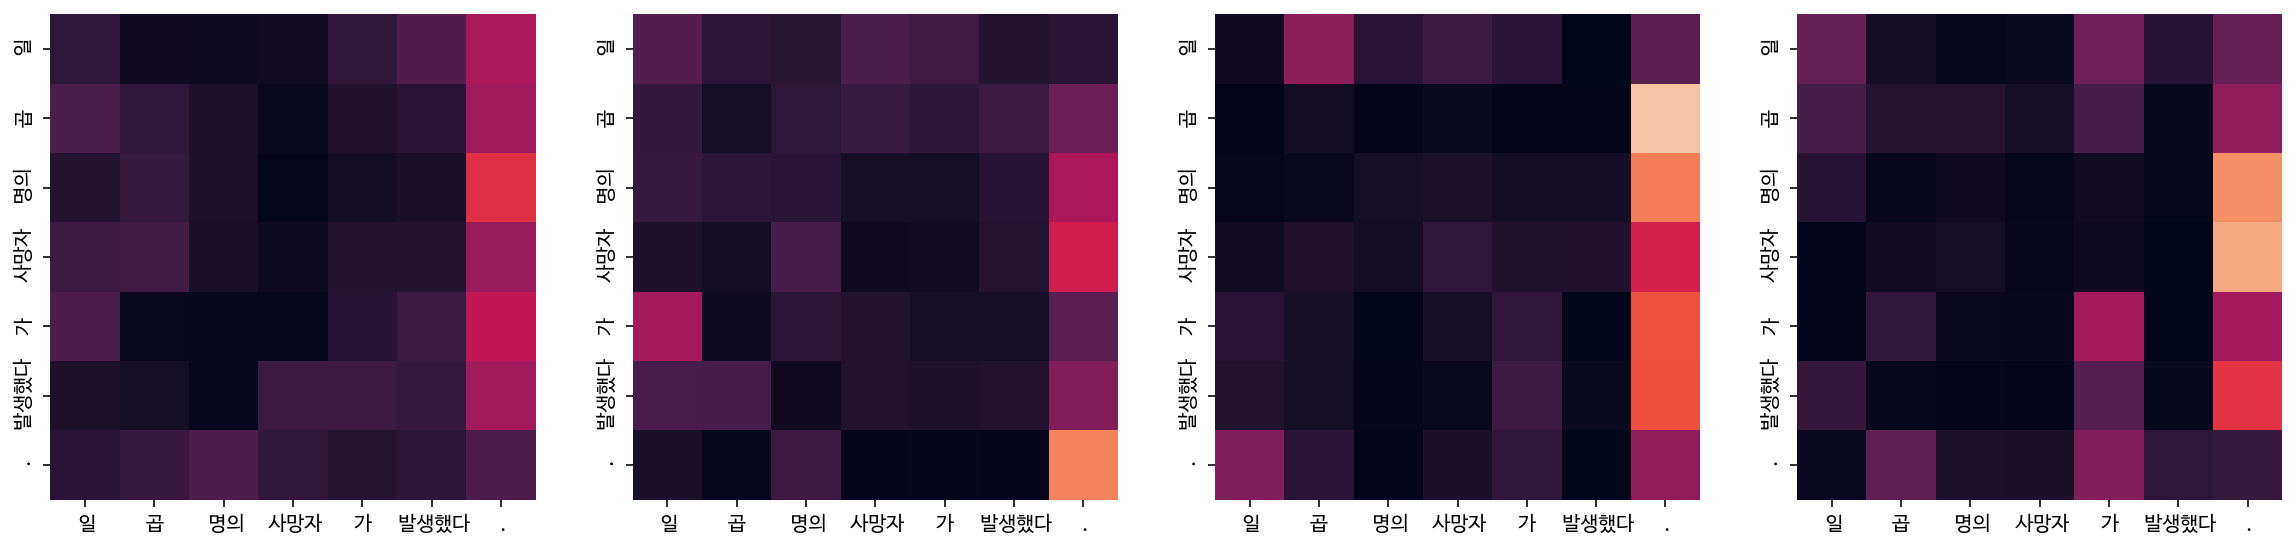

Decoder Self Layer 1


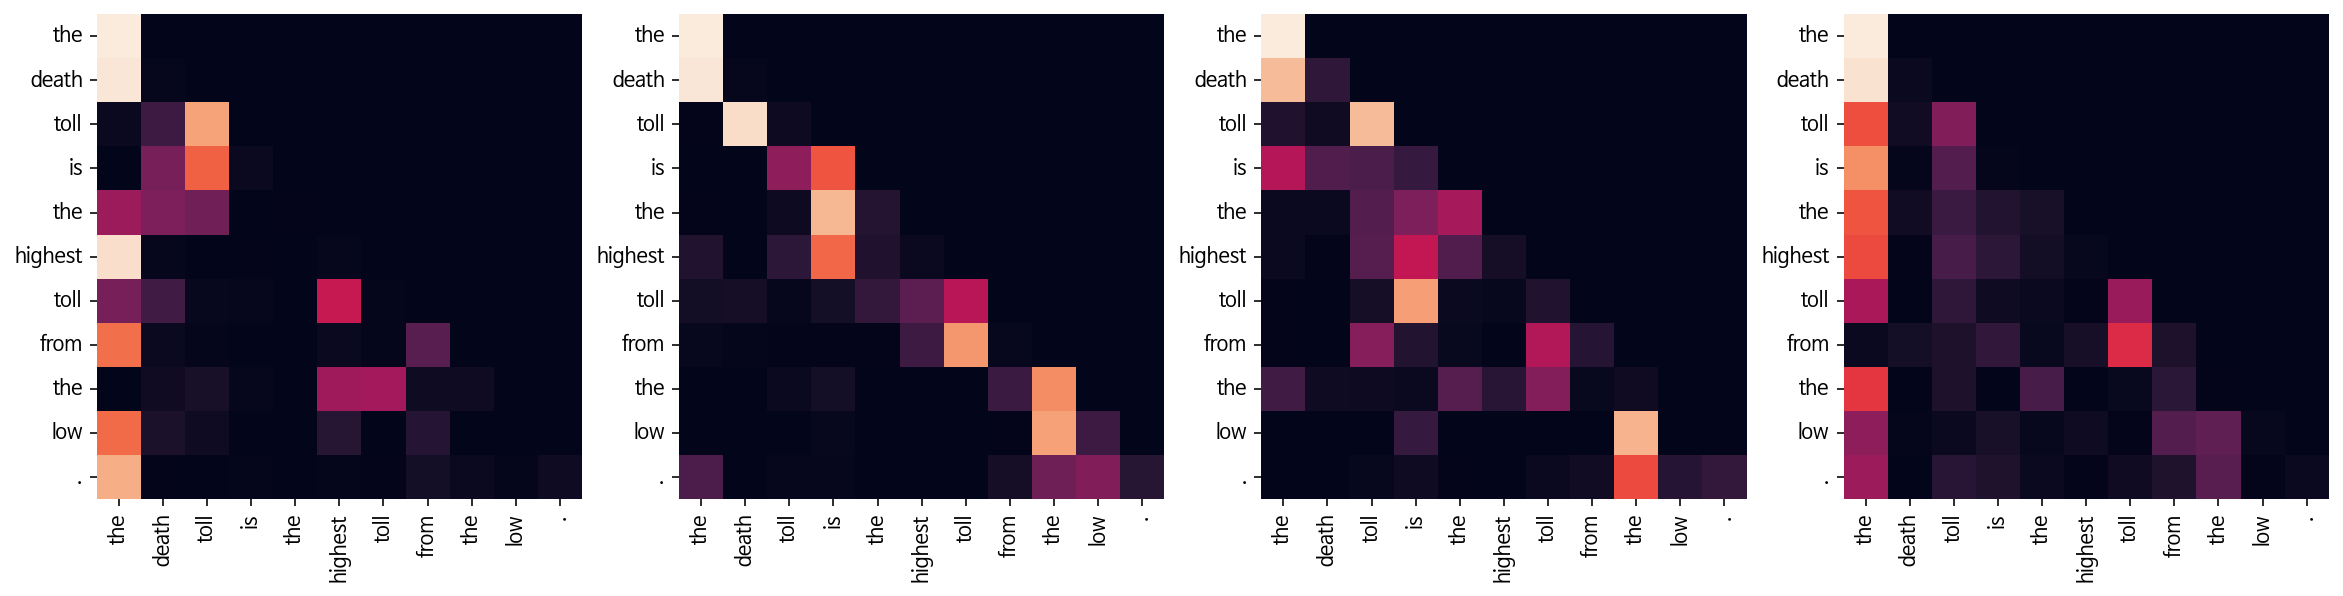

Decoder Src Layer 1


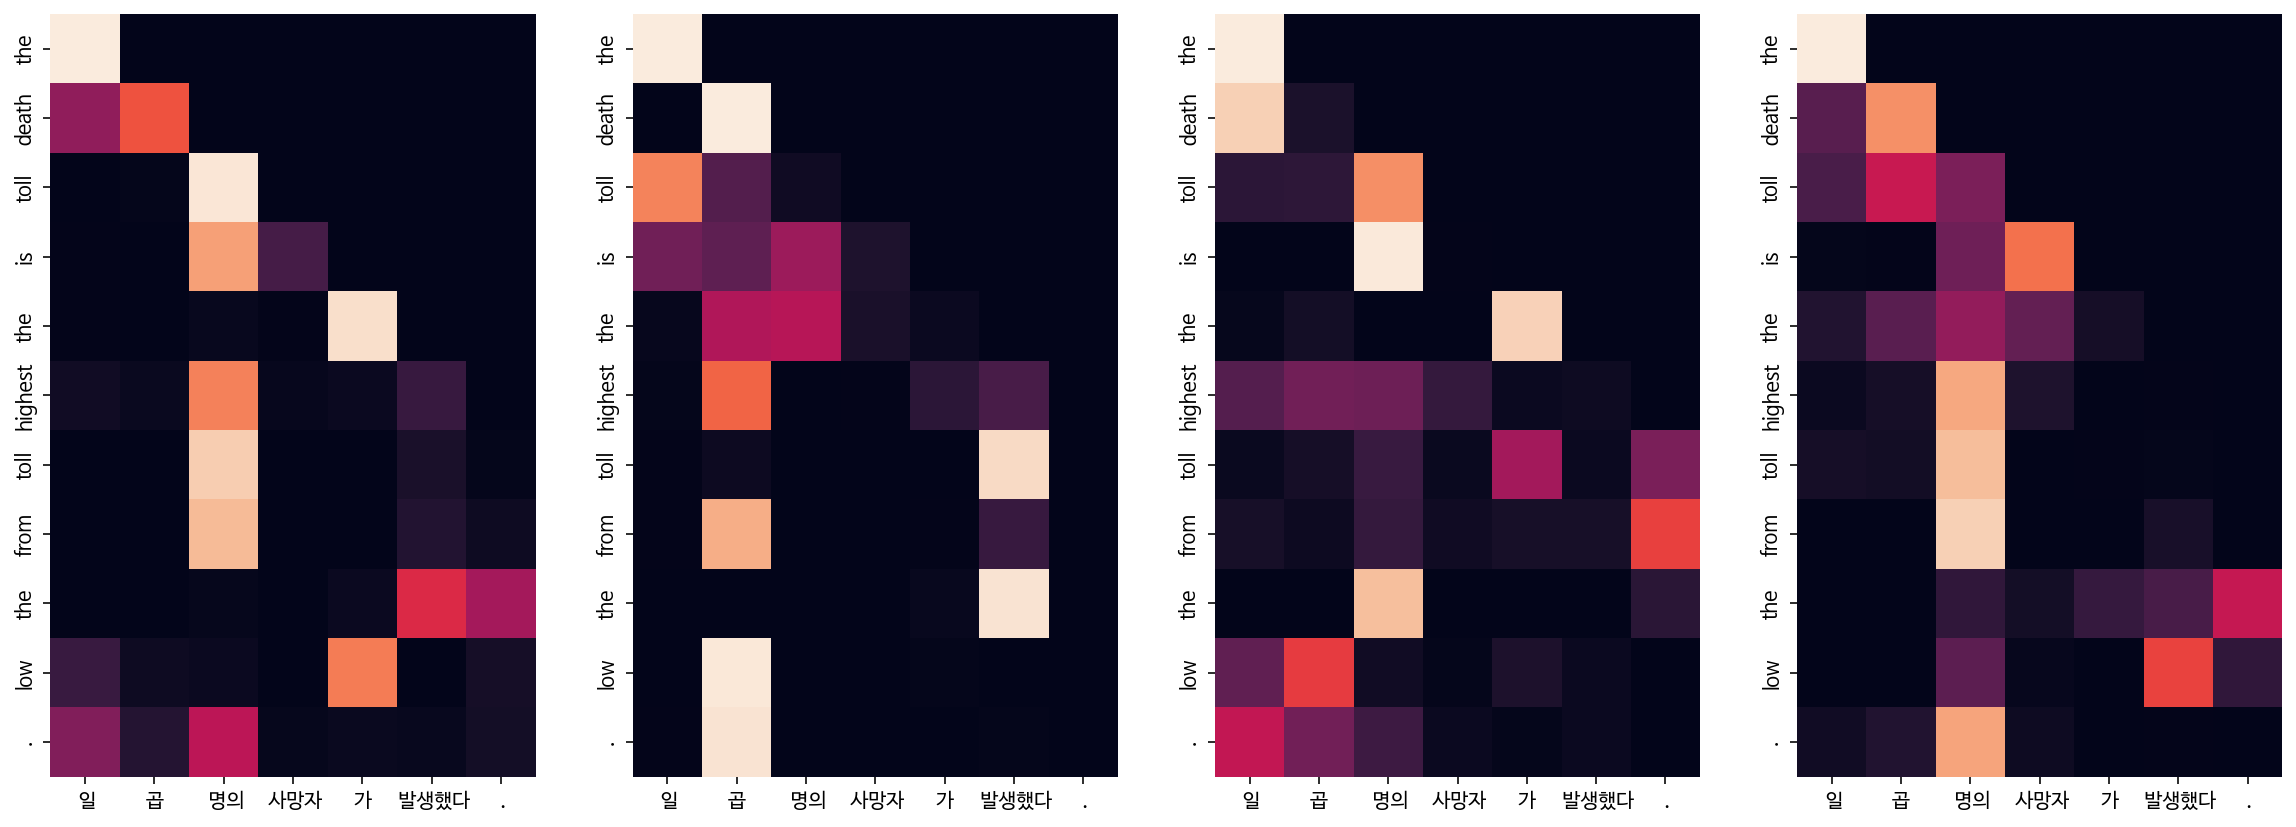

Decoder Self Layer 2


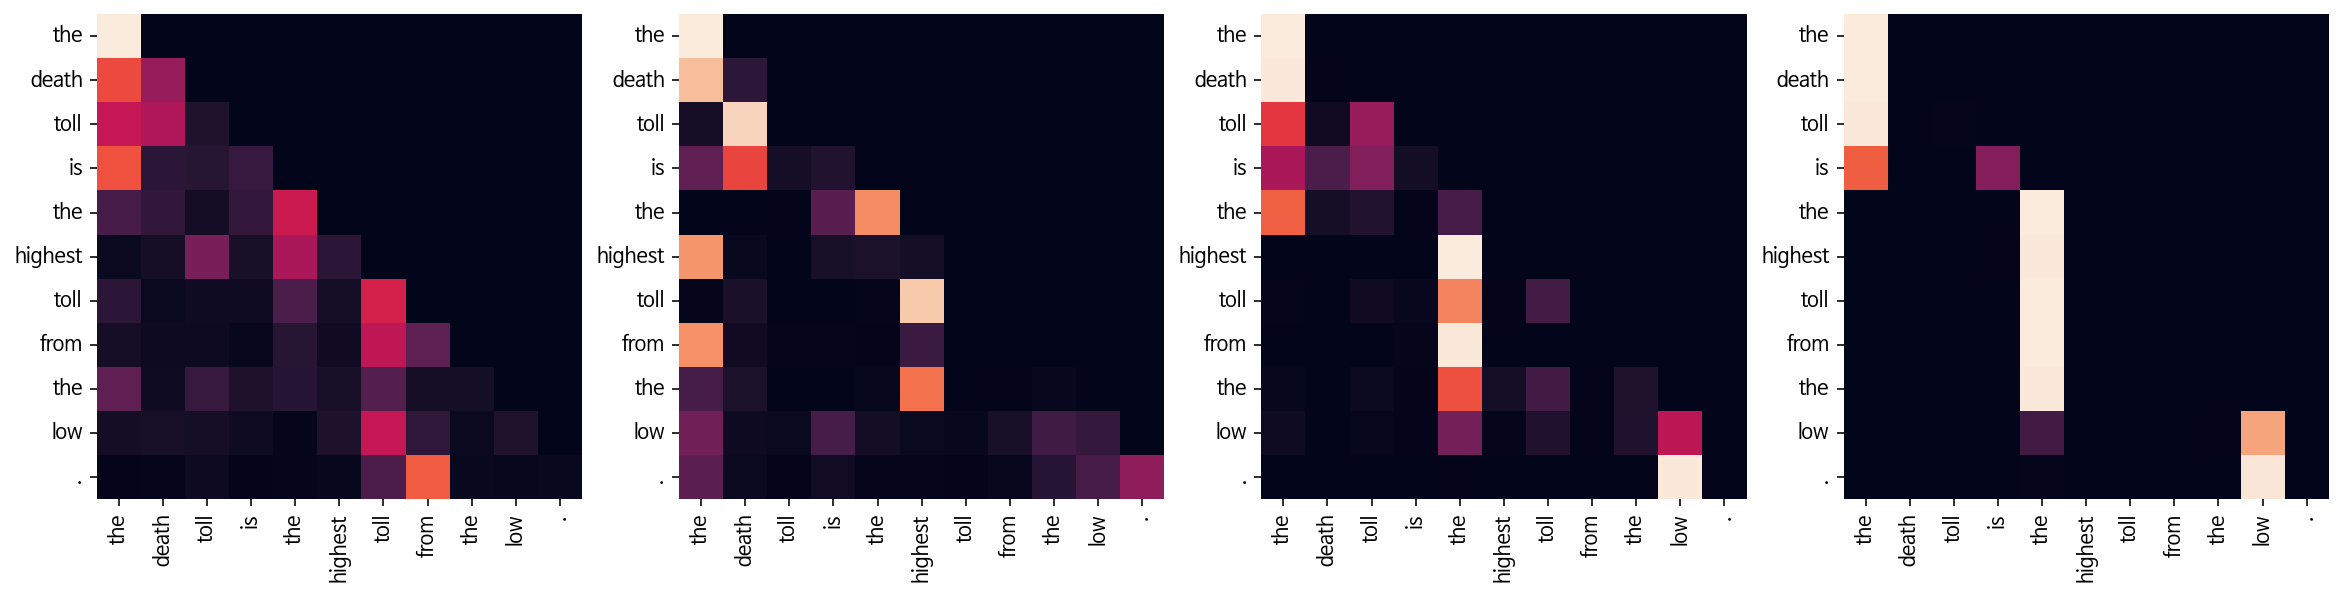

Decoder Src Layer 2


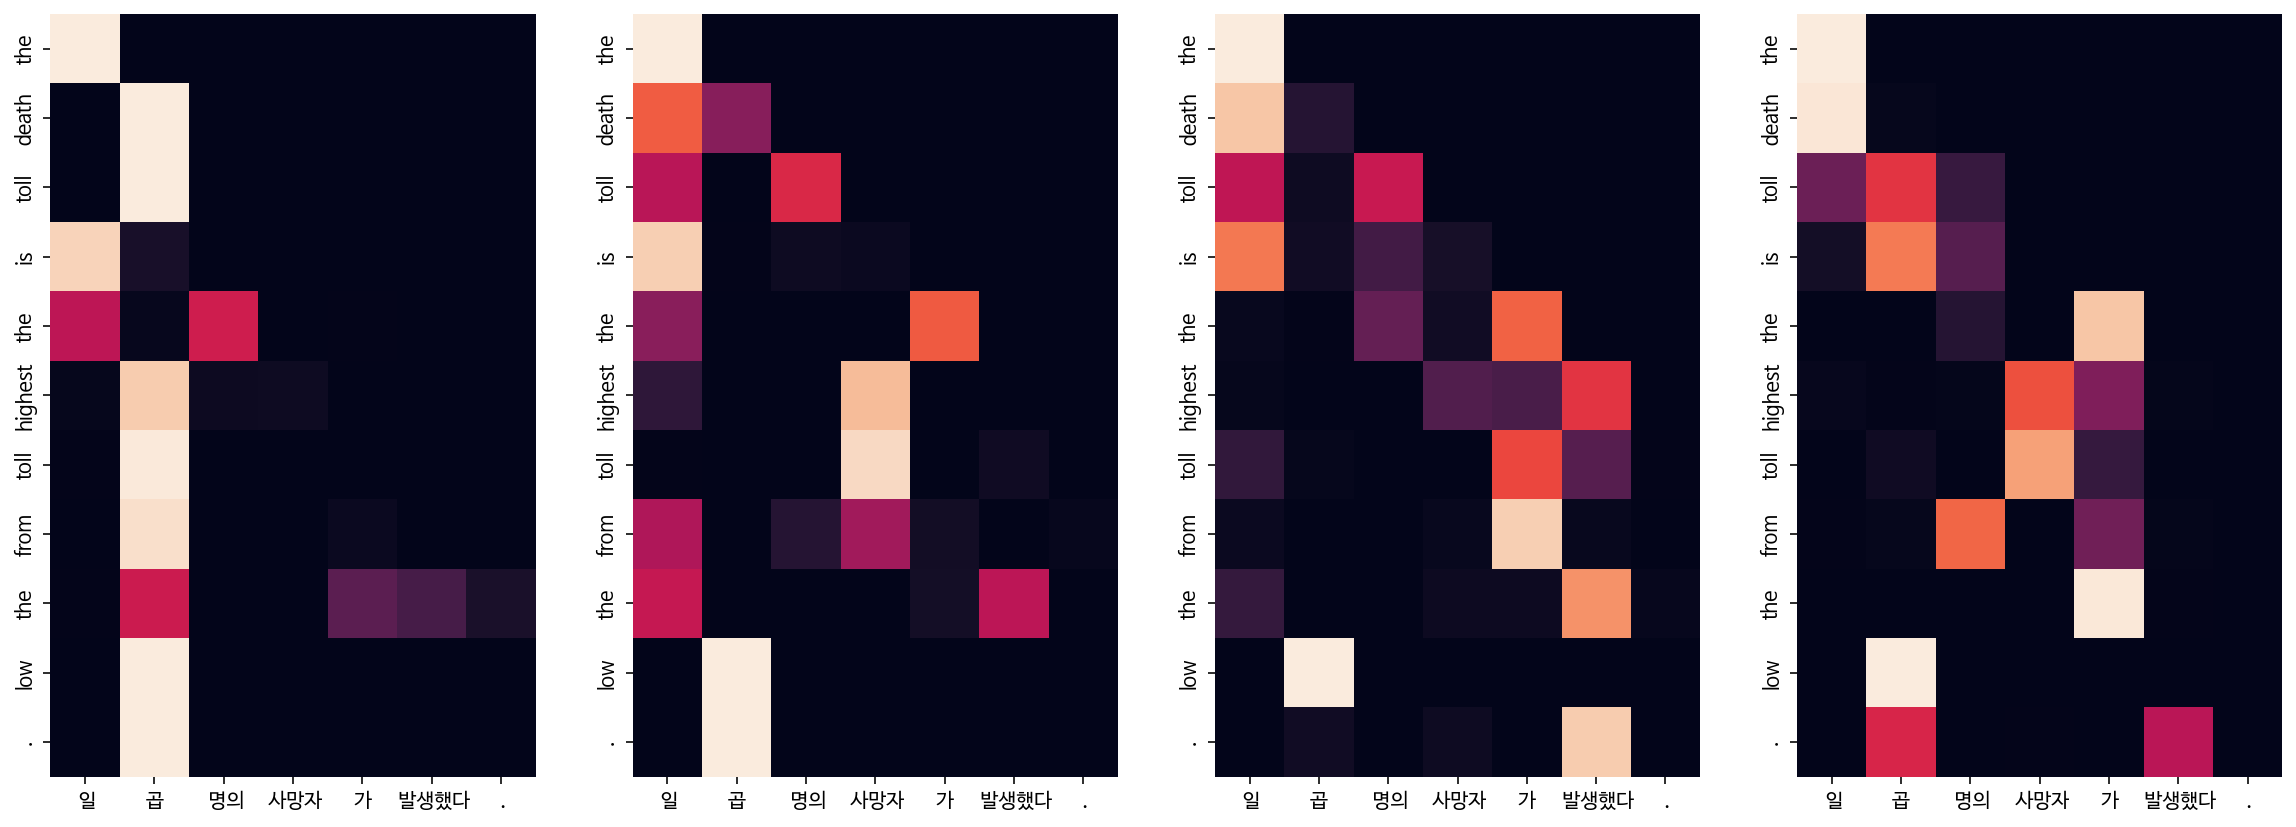

In [24]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

### 루브릭
#### 평가문항	(상세기준)
* 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.	(데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.)
* 2. Transformer 번역기 모델이 정상적으로 구동된다.	(Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.)
* 3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	(제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.)

### 회고
* Sentencepiece를 가져오는 과정에서 좀 헤맸다.
* 학습할 시간이 부족해 batch size와 데이터 크기를 축소했는데, 기존에 주어진 사이즈를 사용했으면 결과가 더 잘 나왔을 수도 있을 것 같다.
* Epoch 증가에 따른 로스 감소가 확연하였다.